In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial import distance
from skbio.diversity import beta_diversity
from skbio.diversity import alpha_diversity
from scipy.cluster import hierarchy
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
import colorcet as cc
from scipy.stats import pearsonr
from scipy.optimize import curve_fit
from matplotlib_venn import venn3
from matplotlib_venn import venn2
from string import ascii_letters
import matplotlib as mpl
from matplotlib.colors import ListedColormap, BoundaryNorm
mpl.rcParams['pdf.fonttype'] = 42

In [2]:
historical_spp = pd.read_csv("../historical_species_lists.csv")
historical_spp.loc[historical_spp["Survey Month_Year"].str.contains("-"), "Year"] = 2006
historical_spp.loc[historical_spp["Year"].isna(), "Year"] = historical_spp["Survey Month_Year"]
historical_spp["Year"] = historical_spp["Year"].astype(int)

/fs/s6k/fast/scratch/8805813_noge4093_mpcs044/ipykernel_352704/386579521.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '['1931' '1931' '1931' '1931' '1931' '1931' '1931' '1931' '1931' '1931'
 '1931' '1982' '1982' '1982' '1982' '1982' '1982' '1982' '1982' '1982'
 '1982' '1982' '1931' '1931' '1931' '1931' '1931' '1931' '1931' '1931'
 '1931' '1931' '1982' '1982' '1982' '1982' '1982' '1982' '1982' '1982'
 '1982' '1982' '1982' '1982' '1982' '1982' '1982' '2024' '2024' '2024'
 '2024' '2024' '2024' '2024' '2024' '2024' '2024' '2024' '2024' '2024'
 '2024' '2024' '2024' '2024' '2024' '2024' '2024' '2024' '2024' '2024'
 '2024' '2024' '2024']' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  historical_spp.loc[historical_spp["Year"].isna(), "Year"] = historical_spp["Survey Month_Year"]


In [3]:
historical_spp = historical_spp.sort_values(["Name", "Species", "Year"]).drop_duplicates(["Name", "Species", "Year"])

In [4]:
metadata = pd.read_csv("../master_metadata.csv")
metadata.loc[metadata["Site"] == "Blank", "Name"] = "Field Blank"
metadata.loc[metadata["Site"] == "Extraction Blank", "Name"] = "Extraction Blank"
metadata.loc[metadata["Site"] == "PCR Blank", "Name"] = "PCR Blank"
metadata = metadata[metadata["EGCF-ID"].notna()].reset_index(drop=True)

In [5]:
asv = pd.read_csv("../dada2_asv_table_with_taxonomy.csv")
asv["Overall_Best"] = asv["Best_Hit_Refseq"]
asv["Overall_Best_Percent_ID"] = asv["Percent_ID_Refseq"]
asv["Overall_Best_Taxonomic_Level"] = asv['Best_Hit_Taxonomic_level_Refseq']
asv.loc[(asv["Percent_ID_Refseq"] < 98) & (asv["evalue_Refseq"] > asv["evalue"]), "Overall_Best"] = asv["Best_Hit"]
asv.loc[(asv["Percent_ID_Refseq"] < 98) & (asv["evalue_Refseq"] > asv["evalue"]), "Overall_Best_Percent_ID"] = asv["Percent_ID"]
asv.loc[(asv["Percent_ID_Refseq"] < 98) & (asv["evalue_Refseq"] > asv["evalue"]), "Overall_Best_Taxonomic_Level"] = asv['Best_Hit_Taxonomic_level']
asv = asv[asv["Class"] == "Actinopteri"].reset_index(drop=True)
fish = asv.copy()
#fish = asv[asv["CountsAcross"] > 10].reset_index(drop=True)
tmp = fish[fish.columns[2:-26].tolist() + ["Overall_Best"]].groupby('Overall_Best').transform('sum')
tmp[[i for i in fish.columns.tolist() if i not in tmp.columns.tolist()]] = fish[[i for i in fish.columns.tolist() if i not in tmp.columns.tolist()]]
tmp = tmp.drop_duplicates(fish.columns[2:-26].tolist() + ["Overall_Best"]).reset_index(drop=True)
fish = tmp.copy()
fish["Primer"] = "MiFish"
for samp in fish.columns[0:-29].tolist():
    fish.loc[fish[samp] < (fish[samp].sum() * 0.001), samp] = 0

In [6]:
fish["in_nsamps"] = fish[fish.columns[0:-29].tolist()].astype(bool).sum(axis=1)
fish = fish[fish["in_nsamps"] > 1].reset_index(drop=True)

In [7]:
asv = pd.read_csv("../dada2_mussels_asv_table_with_taxonomy.csv")
asv = asv[asv["CountsAcross"] > 10].reset_index(drop=True)
mussels = asv[asv["Best_Hit"].notna()][asv["Best_Hit"] != "NA"].reset_index(drop=True)
mussels["Overall_Best"] = mussels["Best_Hit"]
tmp = mussels[mussels.columns[2:-24].tolist() + ["Best_Hit"]].groupby('Best_Hit').transform('sum')
tmp[[i for i in mussels.columns.tolist() if i not in tmp.columns.tolist()]] = mussels[[i for i in mussels.columns.tolist() if i not in tmp.columns.tolist()]]
tmp = tmp.drop_duplicates(mussels.columns[2:-24].tolist() + ["Best_Hit"]).reset_index(drop=True)
mussels = tmp.copy()
mussels["Overall_Best"] = mussels["Best_Hit"]
mussels["Primer"] = "Mussel"
for samp in mussels.columns[0:-27].tolist():
    mussels.loc[mussels[samp] < (mussels[samp].sum() * 0.001), samp] = 0

/fs/s6k/fast/scratch/8805813_noge4093_mpcs044/ipykernel_352704/2494241999.py:1: DtypeWarning: Columns (394,395,396,397,398,399,400,403,404,405,406,407,408,409,412,414) have mixed types. Specify dtype option on import or set low_memory=False.
  asv = pd.read_csv("../dada2_mussels_asv_table_with_taxonomy.csv")
/fs/s6k/fast/scratch/8805813_noge4093_mpcs044/ipykernel_352704/2494241999.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  mussels = asv[asv["Best_Hit"].notna()][asv["Best_Hit"] != "NA"].reset_index(drop=True)


In [8]:
mussels["in_nsamps"] = mussels[mussels.columns[0:-27].tolist()].astype(bool).sum(axis=1)
mussels = mussels[mussels["in_nsamps"] > 1].reset_index(drop=True)

In [9]:
asv = pd.read_csv("../dada2_insects_asv_table_with_taxonomy.csv")
asv = asv[asv["CountsAcross"] > 10].reset_index(drop=True)
insects = asv[asv["Best_Hit"].notna()][asv["Best_Hit"] != "NA"][asv["Best_Hit_Taxonomic_level"].isin(["Species", "Genus", "Family"])].reset_index(drop=True)
insects = insects[insects.columns[2:-21].tolist() + ["Family", 'Order', "Class", "Phylum"]]
tmp = insects.groupby('Family').transform('sum')
tmp[[i for i in insects.columns.tolist() if i not in tmp.columns.tolist()]] = insects[[i for i in insects.columns.tolist() if i not in tmp.columns.tolist()]]
tmp = tmp.drop_duplicates(insects.columns[2:-21].tolist() + ["Family"]).reset_index(drop=True)
insects = tmp.copy()
insects["Overall_Best"] = insects["Family"]
insects["Primer"] = "Insects"
for samp in insects.columns[0:-8].tolist():
    insects.loc[insects[samp] < (insects[samp].sum() * 0.001), samp] = 0

/fs/s6k/fast/scratch/8805813_noge4093_mpcs044/ipykernel_352704/1398026162.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  insects = asv[asv["Best_Hit"].notna()][asv["Best_Hit"] != "NA"][asv["Best_Hit_Taxonomic_level"].isin(["Species", "Genus", "Family"])].reset_index(drop=True)
/fs/s6k/fast/scratch/8805813_noge4093_mpcs044/ipykernel_352704/1398026162.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  insects = asv[asv["Best_Hit"].notna()][asv["Best_Hit"] != "NA"][asv["Best_Hit_Taxonomic_level"].isin(["Species", "Genus", "Family"])].reset_index(drop=True)


In [10]:
insects["in_nsamps"] = insects[insects.columns[0:-8].tolist()].astype(bool).sum(axis=1)
insects = insects[insects["in_nsamps"] > 1].reset_index(drop=True)

In [11]:
mosslake = insects.columns[0:-6].tolist()

In [12]:
joined = pd.concat([fish, mussels, insects]).reset_index(drop=True)
joined = joined[joined["Overall_Best"].notna()].reset_index(drop=True)

In [13]:
rename = metadata[["EGCF-ID", "Name", "Description"]]
rename.columns = ["index", "Name", "Description"]
rename = rename.fillna("NA")

In [14]:
metadata["Merged"] = metadata["Name"] + "_" + metadata["Season"]

In [15]:
subset = joined[joined["Primer"] == "MiFish"].reset_index(drop=True)

In [16]:
subset.loc[subset["Overall_Best"] == "Luxilus", "Overall_Best"] = "Luxilus cornutus"
subset.loc[subset["Overall_Best"] == "Coregonus", "Overall_Best"] = "Coregonus clupeaformis"
subset.loc[subset["Overall_Best"] == "Luxilus cornutus", "Overall_Best_Taxonomic_Level"] = "Species"
subset.loc[subset["Overall_Best"] == "Coregonus clupeaformis", "Overall_Best_Taxonomic_Level"] = "Species"

In [17]:
cov = subset.loc[:, (subset != 0).any(axis=0)]
coverages = []
for samp in cov.columns[:-33].tolist():
    coverages = coverages + [cov[samp].sum()]
q1, q3 = np.percentile(coverages, [25, 75])
iqr = q3 - q1
lowcov = q1 - (1.5 * iqr)

In [20]:
import pandas as pd

# Set up the final outputs
df_all_lakes = pd.DataFrame(columns = ['Family', "Genus", "Overall_Best", "Overall_Best_Taxonomic_Level"])
taxonomy_updated_flags = {}

# Loop through all unique lakes
for lake in metadata["Name"].unique():
    sample_cols = metadata["EGCF-ID"][metadata["Name"] == lake].tolist()

    # Filter and clean the data
    test = subset[sample_cols + ["Family", "Genus", "Overall_Best", "Overall_Best_Taxonomic_Level"]]
    test = test[~(test[sample_cols].fillna(0).astype(float) == 0).all(axis=1)].copy()

    df = test.copy()

    # --------- Genus-to-Species updates ---------
    genus_df = df[df["Overall_Best_Taxonomic_Level"] == "Genus"]
    species_df = df[df["Overall_Best_Taxonomic_Level"] == "Species"]

    for genus_idx, genus_row in genus_df.iterrows():
        genus = genus_row["Genus"]
        genus_samples = genus_row[sample_cols]
        species_matches = species_df[species_df["Genus"] == genus]

        for _, species_row in species_matches.iterrows():
            species_samples = species_row[sample_cols]

            if (genus_samples > 0).equals(species_samples > 0):
                df.at[genus_idx, "Overall_Best"] = species_row["Overall_Best"]
                df.at[genus_idx, "Overall_Best_Taxonomic_Level"] = "Species"
                taxonomy_updated_flags[genus + "_" + lake] = True
                break

    # --------- Family-to-Species updates ---------
    family_df = df[df["Overall_Best_Taxonomic_Level"] == "Family"]
    species_df = df[df["Overall_Best_Taxonomic_Level"] == "Species"]

    for family_idx, family_row in family_df.iterrows():
        family = family_row["Family"]
        family_samples = family_row[sample_cols]
        species_matches = species_df[species_df["Family"] == family]

        for _, species_row in species_matches.iterrows():
            species_samples = species_row[sample_cols]

            if (family_samples > 0).equals(species_samples > 0):
                df.at[family_idx, "Overall_Best"] = species_row["Overall_Best"]
                df.at[family_idx, "Overall_Best_Taxonomic_Level"] = "Species"
                taxonomy_updated_flags[family + "_" + lake] = True
                break

    # Append processed lake data
    tmp = df.groupby(['Family', "Genus", "Overall_Best", "Overall_Best_Taxonomic_Level"]).transform('sum')
    column_sums = tmp.sum(axis=0)
    cols_to_drop = column_sums[column_sums < lowcov].index
    tmp = tmp.drop(columns=cols_to_drop)
    try:
        tmp = pd.concat([tmp, df[['Family', "Genus", "Overall_Best", "Overall_Best_Taxonomic_Level"]]], axis = 1)
        df = tmp.drop_duplicates(subset=['Family', "Genus", "Overall_Best", "Overall_Best_Taxonomic_Level"])
        df_all_lakes = df_all_lakes.merge(df, how = "outer", on = ['Family', "Genus", "Overall_Best", "Overall_Best_Taxonomic_Level"])
    except:
        pass
df_all_lakes = df_all_lakes.fillna(0)

/fs/s6k/fast/scratch/8805813_noge4093_mpcs044/ipykernel_352704/2249230196.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  onescaled[samp] = onescaled[samp] / onescaled[samp].sum() ##Scale to 0 to 1 per samples
/fs/s6k/fast/scratch/8805813_noge4093_mpcs044/ipykernel_352704/2249230196.py:21: UserWarning: The palette list has more values (253) than needed (12), which may not be intended.
  sns.scatterplot(data = finalDf, x = "PC1", y = "PC2", hue = "Full name", palette = cc.glasbey_bw[3:], alpha = 1)


Text(0, 0.5, 'PC2 (15.0889%)')

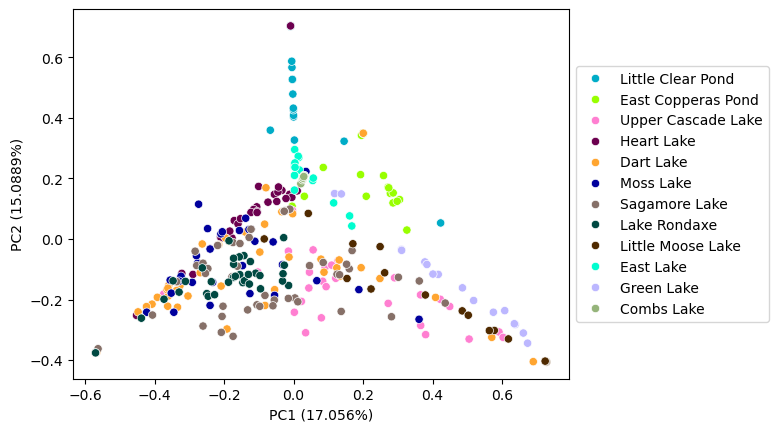

In [21]:
asvs = df_all_lakes[df_all_lakes.columns.tolist()[4:]]
asvs1 = asvs.reset_index(drop=False)
onescaled = asvs
ids = onescaled.columns
for samp in ids:
    onescaled[samp] = onescaled[samp] / onescaled[samp].sum() ##Scale to 0 to 1 per samples
    #onescaled.loc[onescaled[samp] > 0, samp] = 1 ##Scale into binary for each sample
onescaled = onescaled.T.reset_index(drop=False)
onescaled = onescaled.fillna(0)
# Separating out the target
y = onescaled.loc[:,['index']].values
x = onescaled.loc[:, onescaled.columns[1:].tolist()].values
pca = PCA(n_components=20)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents, 
                           columns = ["PC"+str(i+1) for i in list(range(0,20))])
finalDf = pd.concat([principalDf, onescaled[['index']]], axis = 1)
finalDf.columns = ["PC"+str(i+1) for i in list(range(0,20))] + ["EGCF-ID"]
finalDf = finalDf.merge(metadata[["Name", "Full name", "EGCF-ID", "Season", "Description"]], how = "left", on = "EGCF-ID")
finalDf.loc[finalDf["Name"] == "Field Blank", "Name"] = finalDf["Full name"]
sns.scatterplot(data = finalDf, x = "PC1", y = "PC2", hue = "Full name", palette = cc.glasbey_bw[3:], alpha = 1)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("PC1 (" + str(round(pca.explained_variance_ratio_[0] * 100, 4)) + "%)")
plt.ylabel("PC2 (" + str(round(pca.explained_variance_ratio_[1] * 100, 4)) + "%)")
#plt.savefig("../pca_onescaled.pdf", dpi = 300, bbox_inches='tight')

In [22]:
finalDf = pd.concat([finalDf, onescaled], axis = 1)

In [23]:
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.linear_model import SGDOneClassSVM
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import mahalanobis
import numpy as np
import pandas as pd

df_group = finalDf.copy()
features = onescaled.columns.tolist()[1:]

# Initialize columns
outlier_cols = ['outlier_if', 'outlier_lof', 'outlier_svm', 'outlier_centroid', 'outlier_mahal']
for col in outlier_cols:
    df_group[col] = np.nan

# Iterate through Name groups
for name, group in df_group.groupby("Full name"):
    if len(group) < 5:
        # Skip small groups or mark as NaN
        df_group.loc[group.index, outlier_cols] = -999
        continue

    X = group[features].values
    X_scaled = StandardScaler().fit_transform(X)

    # Isolation Forest
    iso = IsolationForest(n_estimators=100, contamination="auto", random_state=42)
    iso_labels = iso.fit_predict(X_scaled) == -1

    # LOF
    lof = LocalOutlierFactor(n_neighbors=4, contamination="auto")
    lof_labels = lof.fit_predict(X_scaled) == -1

    # One-Class SVM
    svm = SGDOneClassSVM(nu=0.1, random_state=42)
    svm.fit(X_scaled)
    svm_labels = svm.predict(X_scaled) == -1

    # DBSCAN
    db = DBSCAN(eps=0.7, min_samples=3)
    dbscan_labels = db.fit_predict(X_scaled) == -1

    # Centroid Distance
    centroid = X_scaled.mean(axis=0)
    dists = np.linalg.norm(X_scaled - centroid, axis=1)
    threshold = np.percentile(dists, 90)
    centroid_labels = dists > threshold

    # Mahalanobis Distance
    try:
        cov_inv = np.linalg.inv(np.cov(X_scaled.T))
        mahal_dists = [mahalanobis(x, centroid, cov_inv) for x in X_scaled]
        threshold_mahal = np.percentile(mahal_dists, 90)
        mahal_labels = np.array(mahal_dists) > threshold_mahal
    except np.linalg.LinAlgError:
        mahal_labels = np.full(X_scaled.shape[0], False)

    # Assign results back
    df_group.loc[group.index, "outlier_if"] = iso_labels
    df_group.loc[group.index, "outlier_lof"] = lof_labels
    df_group.loc[group.index, "outlier_svm"] = svm_labels
    df_group.loc[group.index, "outlier_dbscan"] = dbscan_labels
    df_group.loc[group.index, "outlier_centroid"] = centroid_labels
    df_group.loc[group.index, "outlier_mahal"] = mahal_labels

# Compute combined scores
bool_cols = ['outlier_if', 'outlier_lof', 'outlier_svm', "outlier_dbscan", 'outlier_centroid', 'outlier_mahal']
df_group[bool_cols] = df_group[bool_cols].astype(float)  # prevent type issues

df_group["outlier_score"] = df_group[bool_cols].sum(axis=1)
df_group["outlier_consensus_2plus"] = df_group["outlier_score"] >= 2
df_group["outlier_consensus_3plus"] = df_group["outlier_score"] >= 3

/fs/s6k/fast/scratch/8805813_noge4093_mpcs044/ipykernel_352704/1496607076.py:61: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[False  True False  True False  True False False False  True False  True
 False False False False]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_group.loc[group.index, "outlier_if"] = iso_labels
/fs/s6k/fast/scratch/8805813_noge4093_mpcs044/ipykernel_352704/1496607076.py:62: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[False  True False  True False False False False False  True False  True
 False False False False]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_group.loc[group.index, "outlier_lof"] = lof_labels
/fs/s6k/fast/scratch/8805813_noge4093_mpcs044/ipykernel_352704/1496607076.py:63: FutureWarn

In [24]:
df_group["outlier_marker"] = np.where(df_group["outlier_score"] > 2, "Outlier", "Inlier")

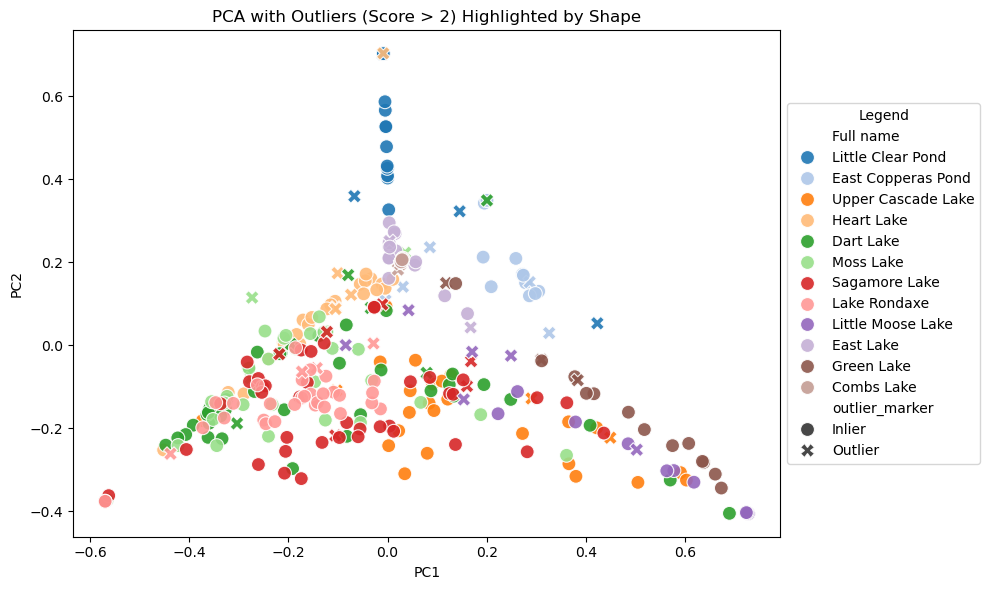

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

sns.scatterplot(
    data=df_group[df_group['outlier_score'] != -999],  # skip groups too small
    x="PC1", y="PC2",
    hue="Full name",                     # color by group
    style="outlier_marker",        # shape by outlier status
    palette="tab20",               # or any palette you like
    markers={"Outlier": "X", "Inlier": "o"},
    s=100,                         # larger points for visibility
    alpha=0.9
)

plt.title("PCA with Outliers (Score > 2) Highlighted by Shape")
plt.legend(bbox_to_anchor=(1, 0.5), loc='center left', title="Legend")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.tight_layout()
plt.savefig("../pca_outlier_shape_score_gt2.pdf", dpi=300)

In [27]:
df_group["EGCF-ID"][df_group['outlier_score'] > 2].tolist()

['387',
 '45',
 '373',
 '68',
 '221',
 '220',
 '217',
 '218',
 '113',
 '214',
 '136',
 '239',
 '126',
 '231',
 '76',
 '75',
 '367',
 '368',
 '71',
 '282',
 '55',
 '290',
 '281',
 '53',
 '285',
 '21',
 '264',
 '274',
 '6',
 '7',
 '330',
 '349',
 '318',
 '323',
 '335',
 '90',
 '96',
 '91',
 '154',
 '145',
 '155',
 '141',
 '150',
 '142',
 '162',
 '157',
 '176',
 '180',
 '179',
 '196',
 '202']

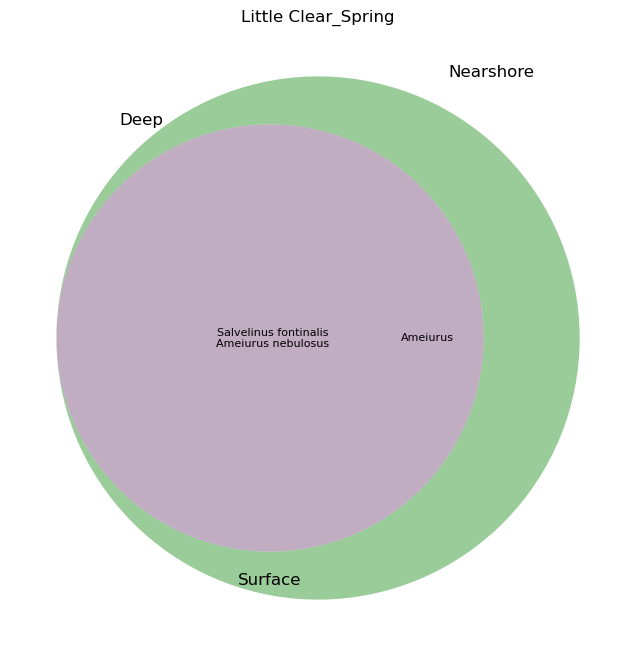

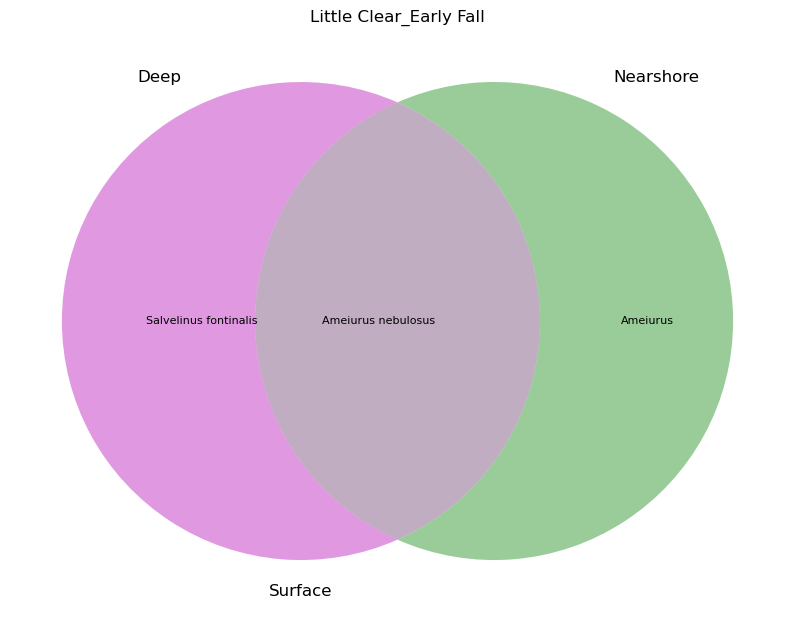

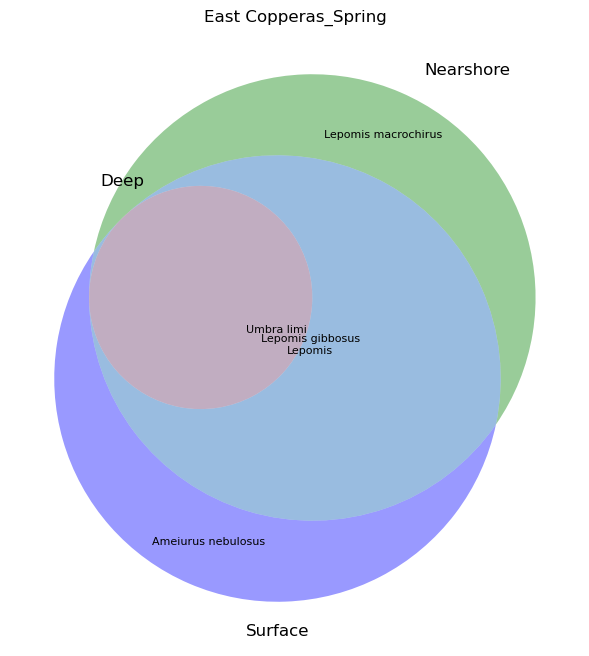

/user/noge4093/miniconda3/envs/orbicella/lib/python3.9/site-packages/matplotlib_venn/layout/venn3/pairwise.py:169: UserWarning: Bad circle positioning.
  warnings.warn("Bad circle positioning.")


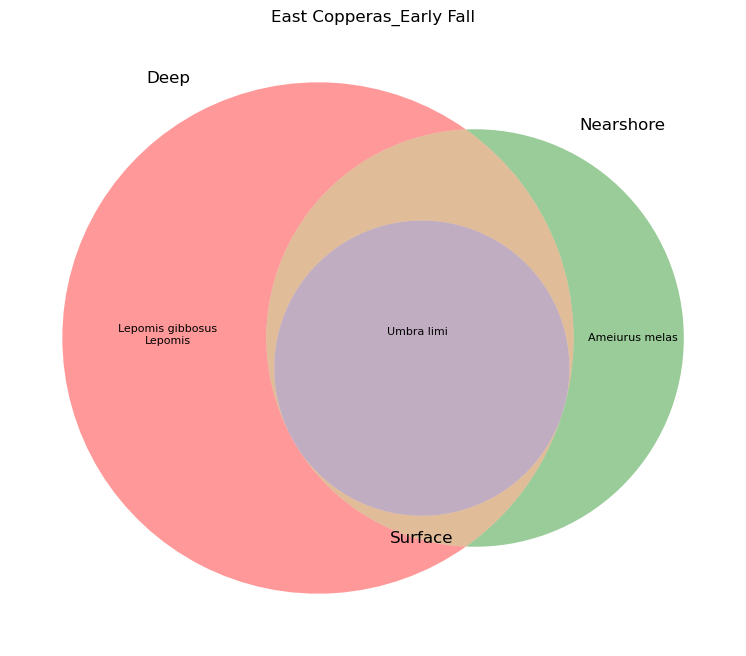

/user/noge4093/miniconda3/envs/orbicella/lib/python3.9/site-packages/matplotlib_venn/layout/venn3/pairwise.py:169: UserWarning: Bad circle positioning.
  warnings.warn("Bad circle positioning.")


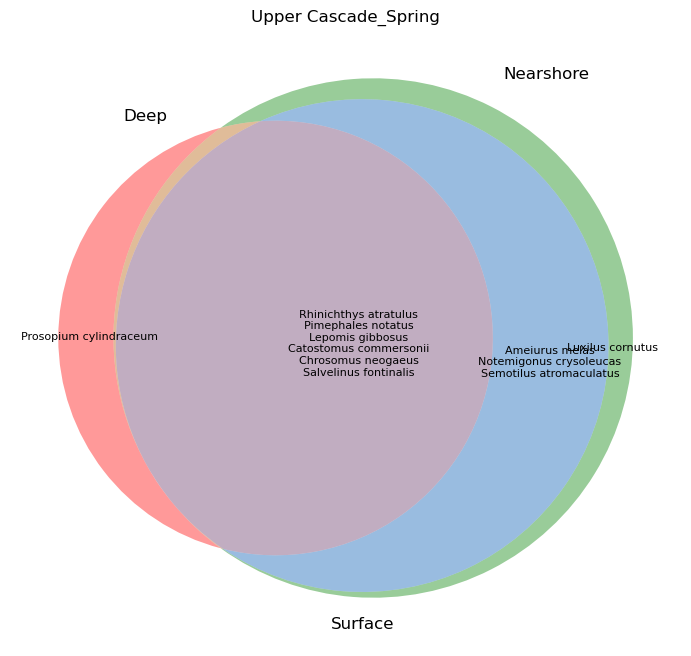

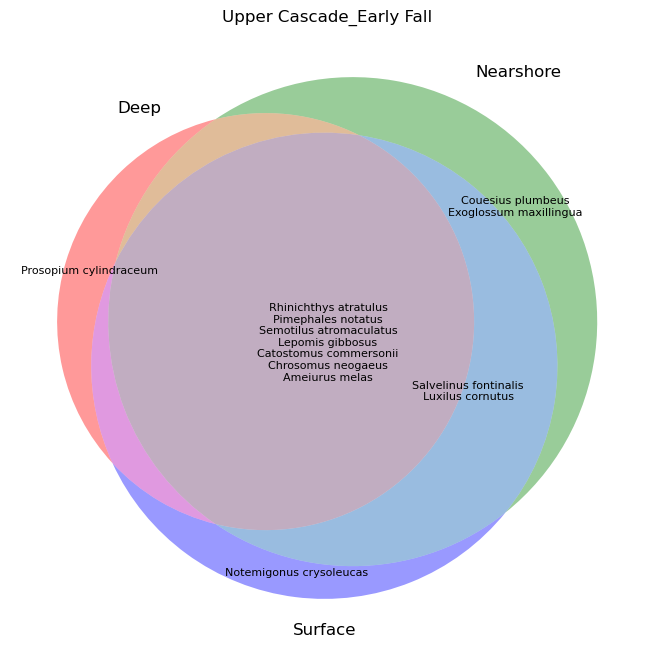

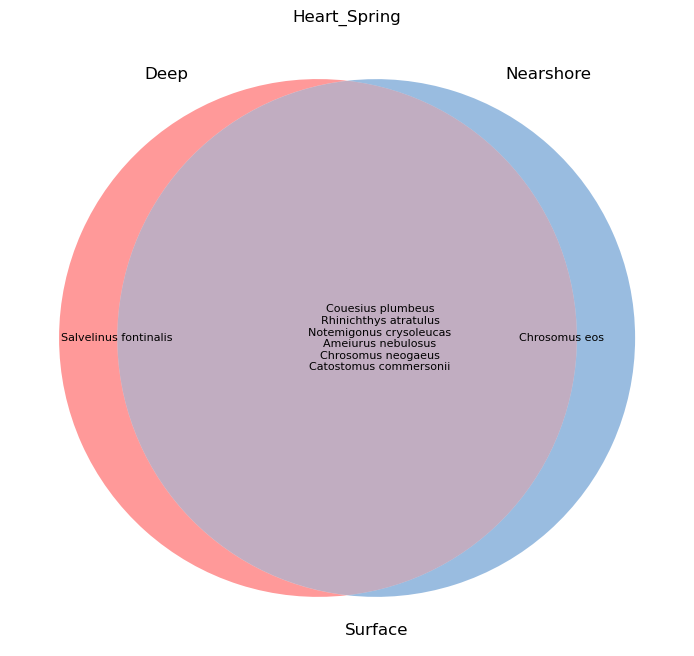

/user/noge4093/miniconda3/envs/orbicella/lib/python3.9/site-packages/matplotlib_venn/layout/venn3/pairwise.py:169: UserWarning: Bad circle positioning.
  warnings.warn("Bad circle positioning.")


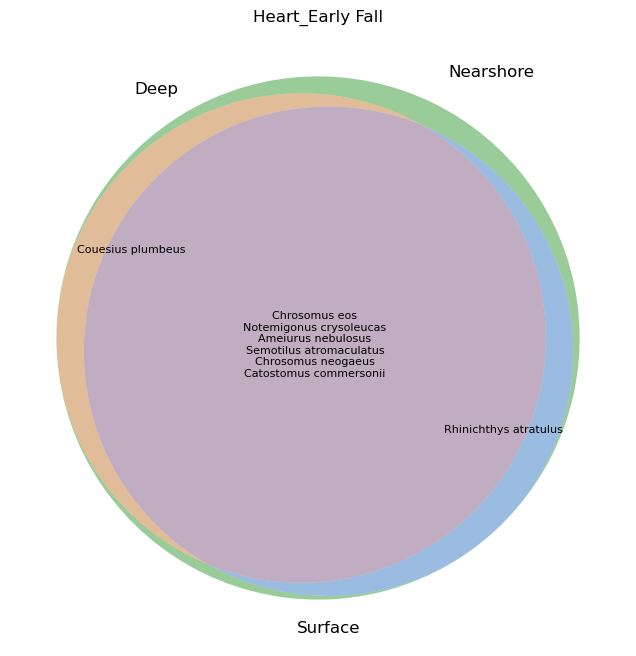

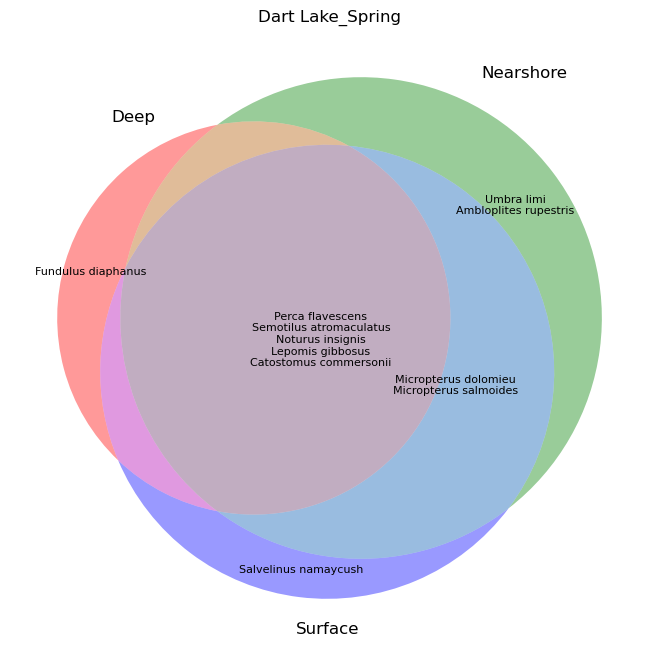

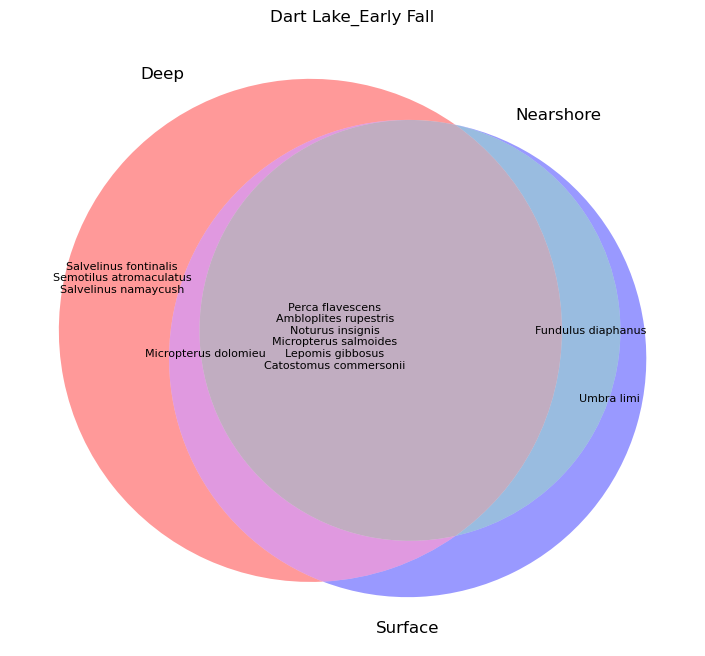

/user/noge4093/miniconda3/envs/orbicella/lib/python3.9/site-packages/matplotlib_venn/layout/venn3/pairwise.py:169: UserWarning: Bad circle positioning.
  warnings.warn("Bad circle positioning.")


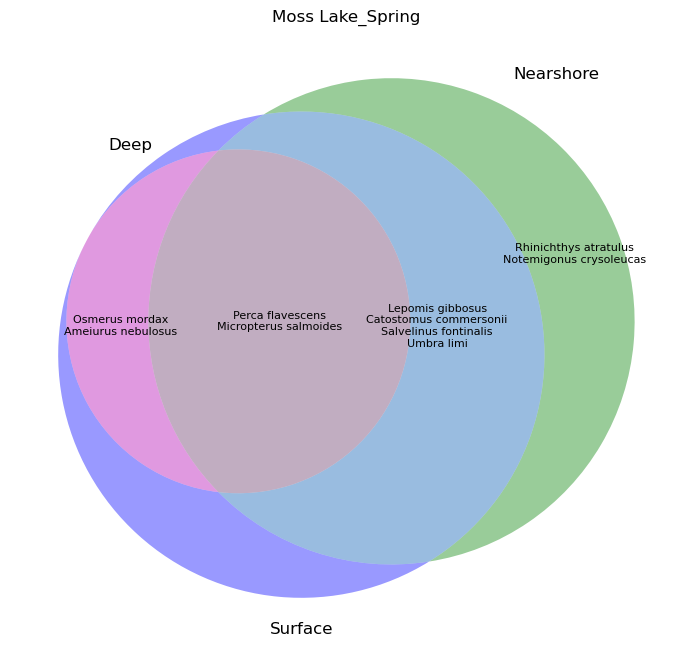

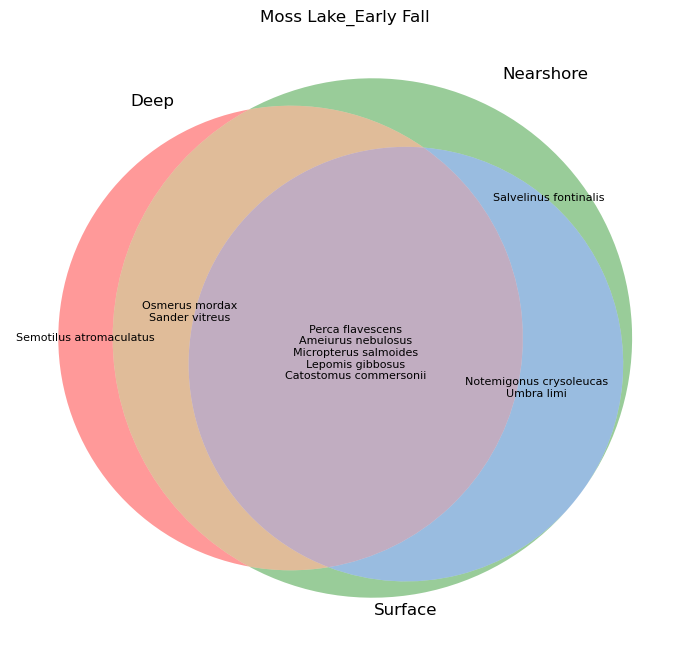

/user/noge4093/miniconda3/envs/orbicella/lib/python3.9/site-packages/matplotlib_venn/layout/venn3/pairwise.py:169: UserWarning: Bad circle positioning.
  warnings.warn("Bad circle positioning.")


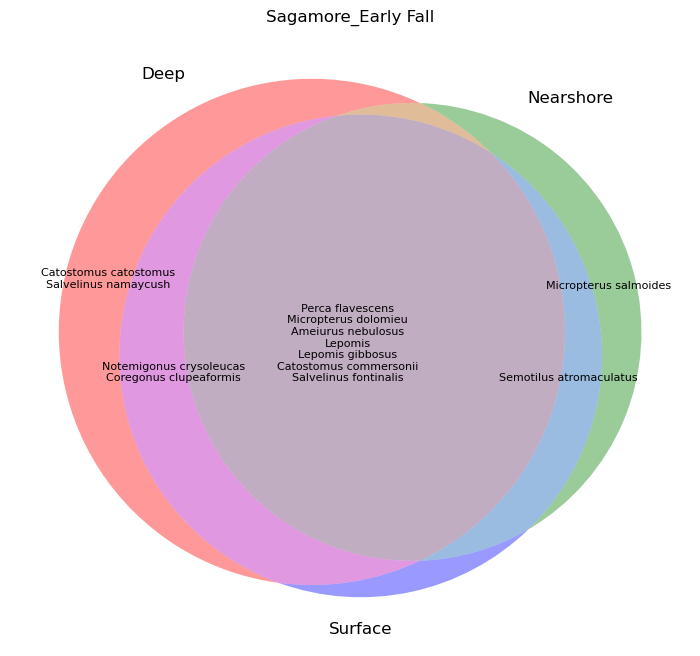

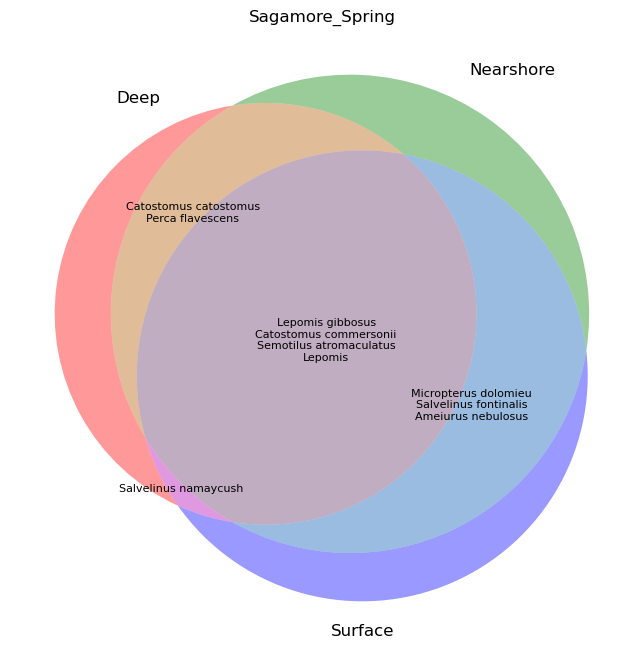

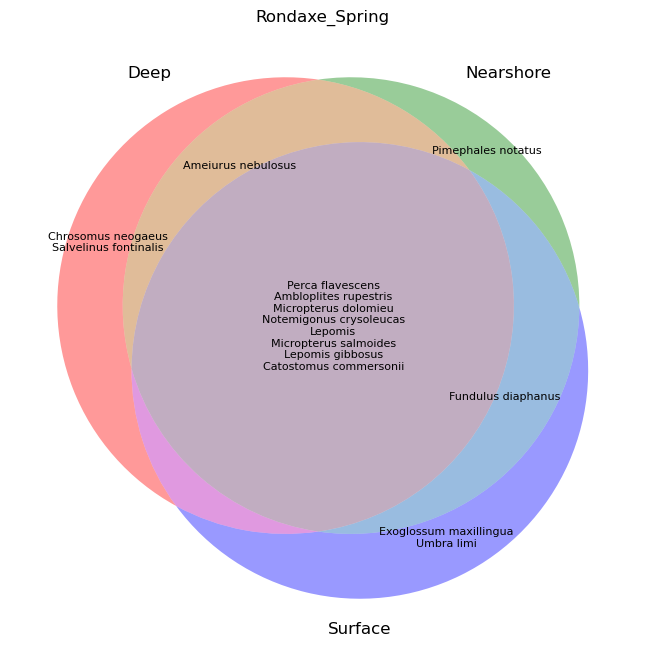

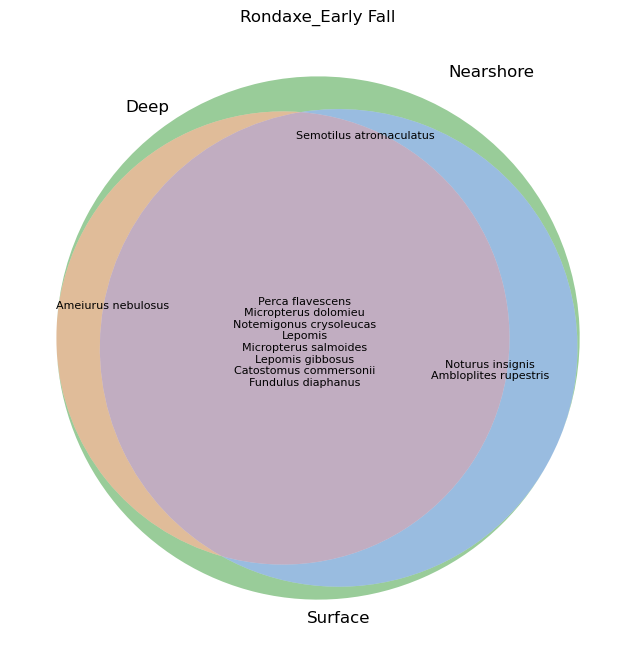

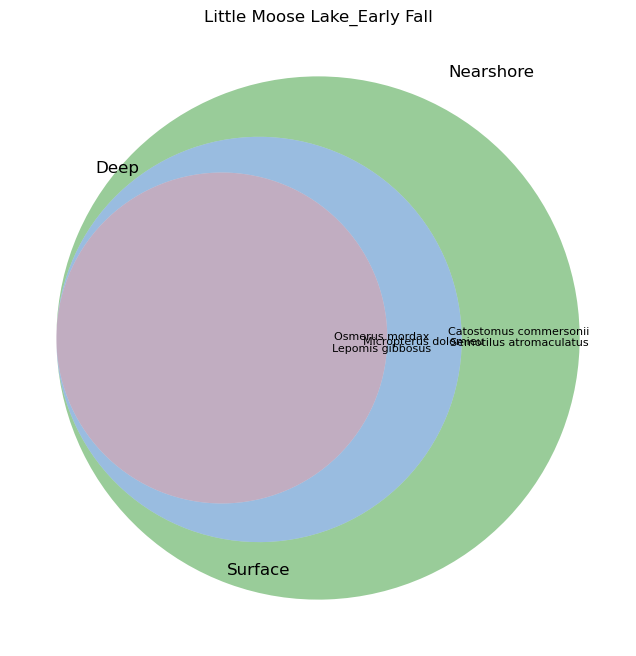

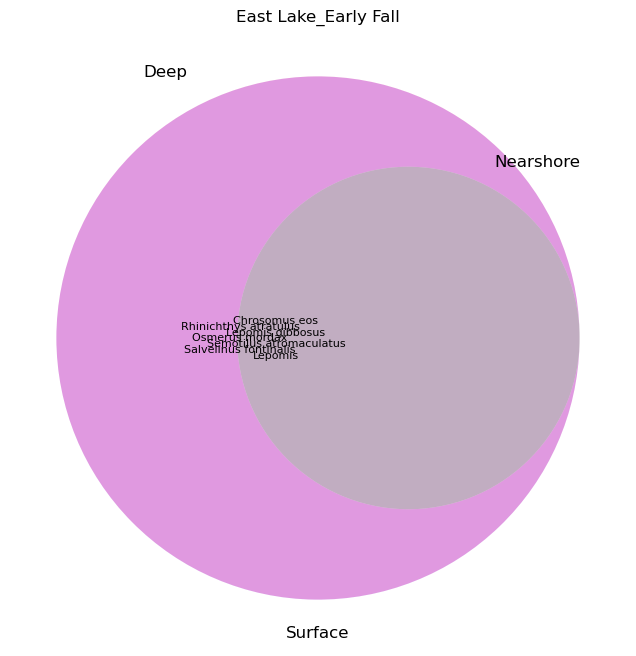

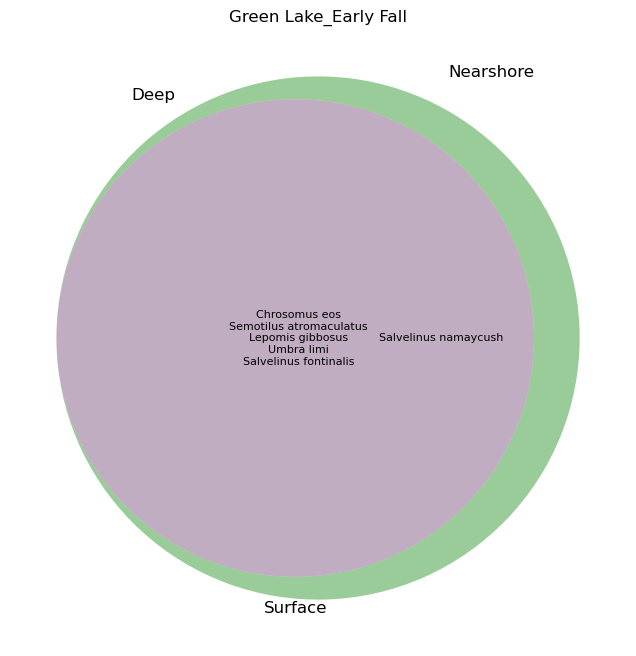

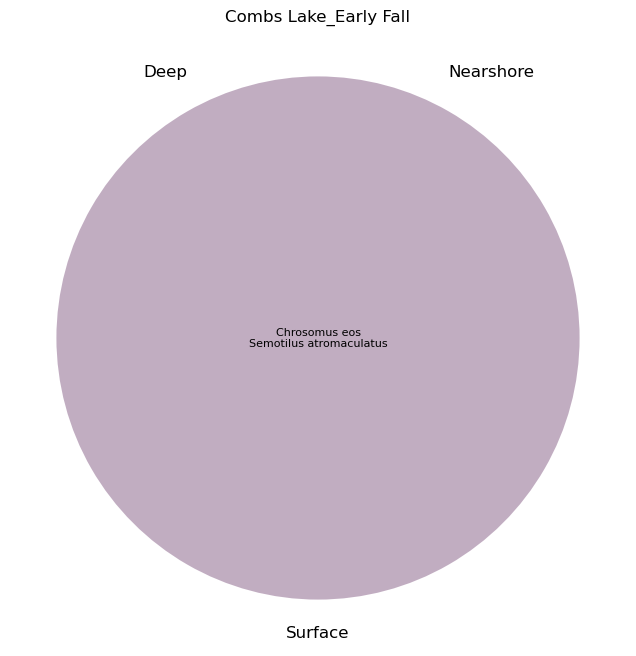

/user/noge4093/miniconda3/envs/orbicella/lib/python3.9/site-packages/matplotlib_venn/layout/venn3/pairwise.py:97: UserWarning: All circles have zero area.
  warnings.warn("All circles have zero area.")


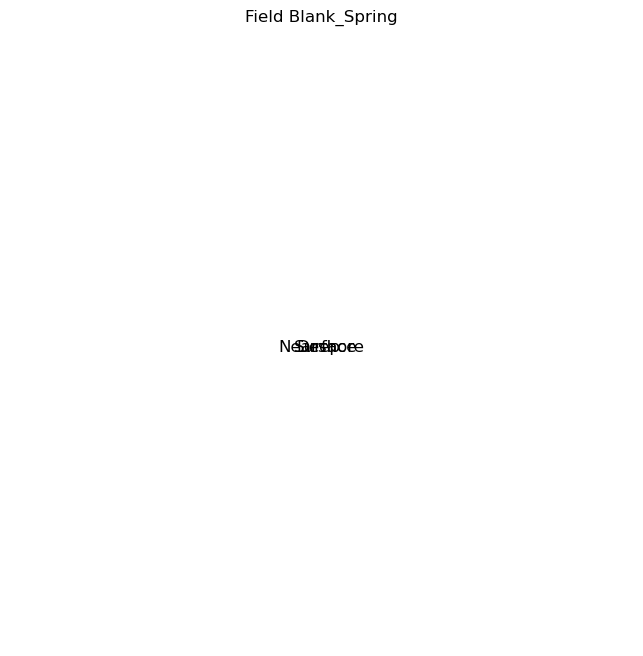

/user/noge4093/miniconda3/envs/orbicella/lib/python3.9/site-packages/matplotlib_venn/layout/venn3/pairwise.py:97: UserWarning: All circles have zero area.
  warnings.warn("All circles have zero area.")


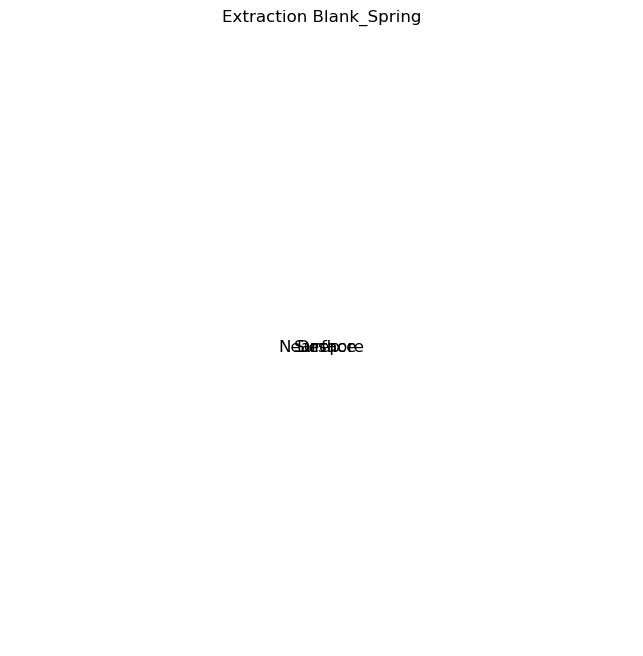

/user/noge4093/miniconda3/envs/orbicella/lib/python3.9/site-packages/matplotlib_venn/layout/venn3/pairwise.py:97: UserWarning: All circles have zero area.
  warnings.warn("All circles have zero area.")


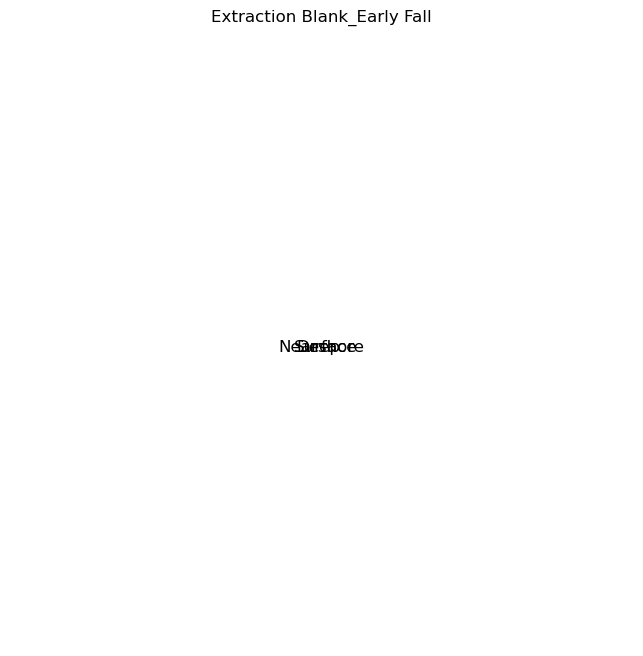

/user/noge4093/miniconda3/envs/orbicella/lib/python3.9/site-packages/matplotlib_venn/layout/venn3/pairwise.py:97: UserWarning: All circles have zero area.
  warnings.warn("All circles have zero area.")


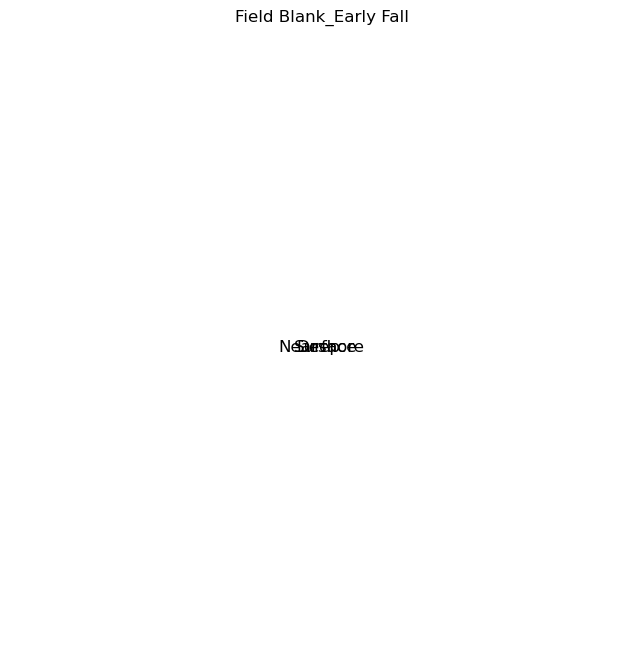

/user/noge4093/miniconda3/envs/orbicella/lib/python3.9/site-packages/matplotlib_venn/layout/venn3/pairwise.py:97: UserWarning: All circles have zero area.
  warnings.warn("All circles have zero area.")


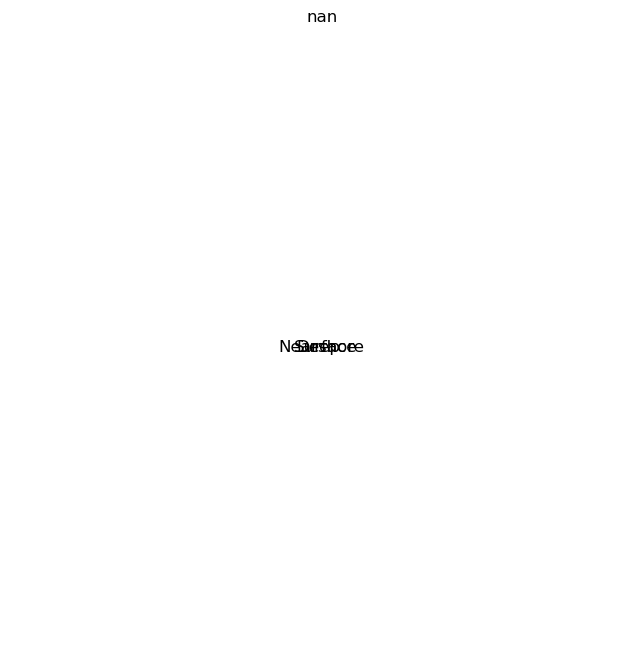

/user/noge4093/miniconda3/envs/orbicella/lib/python3.9/site-packages/matplotlib_venn/layout/venn3/pairwise.py:97: UserWarning: All circles have zero area.
  warnings.warn("All circles have zero area.")


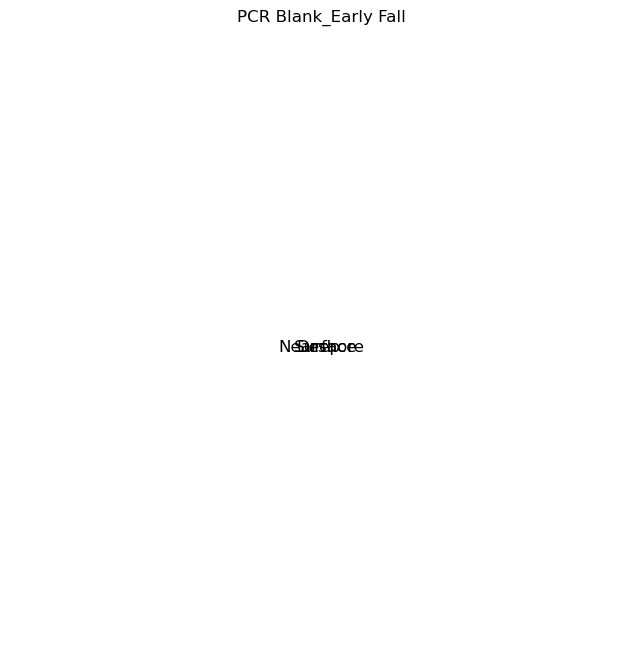

In [28]:
mifish = df_all_lakes.copy()
summary = pd.DataFrame()
filteredsamps = mifish.columns.tolist()
for site_season in metadata["Merged"].unique().tolist():
    plt.figure(figsize=(10, 8))
    deep = (mifish[[i for i in metadata["EGCF-ID"]
              [metadata["Merged"] == site_season]
              [metadata["Description"] == "Deep"].tolist() if i in filteredsamps] + 
              ["Overall_Best"]])
    deep = deep[[i for i in deep.columns.tolist() if i not in df_group["EGCF-ID"][df_group['outlier_score'] > 2].tolist()]]
    deep["sum"] = deep[deep.columns[0:-1].tolist()].sum(axis=1, numeric_only=True)
    deep = deep[deep["sum"] > 0].reset_index(drop=True)
    deepsplist = deep["Overall_Best"].tolist()
    nearshore = (mifish[[i for i in metadata["EGCF-ID"]
              [metadata["Merged"] == site_season]
              [metadata["Description"].isin(["Nearshore", "Near Shore"])].tolist() if i in filteredsamps]  + 
                  ["Overall_Best"]])
    nearshore = nearshore[[i for i in nearshore.columns.tolist() if i not in df_group["EGCF-ID"][df_group['outlier_score'] > 2].tolist()]]
    nearshore["sum"] = nearshore[nearshore.columns[0:-1].tolist()].sum(axis=1, numeric_only=True)
    nearshore = nearshore[nearshore["sum"] > 0].reset_index(drop=True)
    nearshoresplist = nearshore["Overall_Best"].tolist()
    surface = (mifish[[i for i in metadata["EGCF-ID"]
              [metadata["Merged"] == site_season]
              [metadata["Description"] == "Surface"].tolist() if i in filteredsamps]  + 
                  ["Overall_Best"]])
    surface = surface[[i for i in surface.columns.tolist() if i not in df_group["EGCF-ID"][df_group['outlier_score'] > 2].tolist()]]
    surface["sum"] = surface[surface.columns[0:-1].tolist()].sum(axis=1, numeric_only=True)
    surface = surface[surface["sum"] > 0].reset_index(drop=True)
    surfacesplist = surface["Overall_Best"].tolist()
    deepsplist = set(deepsplist)
    nearshoresplist = set(nearshoresplist)
    surfacesplist = set(surfacesplist)

    # Define your species sets for three habitats
    # Plot the Venn diagram
    venn = venn3([deepsplist, 
                  nearshoresplist, 
                  surfacesplist], 
                 ('Deep', 'Nearshore', 'Surface'))
    tmp7 = pd.DataFrame(data = [len(deepsplist - nearshoresplist - surfacesplist), 
                                len(nearshoresplist - deepsplist - surfacesplist), 
                                len(surfacesplist - deepsplist - nearshoresplist), 
                                len((deepsplist & nearshoresplist) - surfacesplist), 
                                len((deepsplist & surfacesplist) - nearshoresplist), 
                                len((nearshoresplist & surfacesplist) - deepsplist), 
                                len(deepsplist & nearshoresplist & surfacesplist)]).T
    tmp7.columns = ["deeponly", "nearshoreonly", "shallowonly", "deepnearshore", "deepsurface", "nearshoresurface", "intersectall"]
    tmp7["lake"] = site_season
    summary = pd.concat([summary, tmp7]).reset_index(drop=True)

    # Now manually set the labels for each subset
    # The subsets are labeled by region IDs, like '100', '010', '001', '110', etc.
    try:   # Example for region '100' (only in A)
        venn.get_label_by_id('100').set_text('\n'.join(deepsplist - nearshoresplist - surfacesplist))
    except:
        pass
    # Only in B
    try:
        venn.get_label_by_id('010').set_text('\n'.join(nearshoresplist - deepsplist - surfacesplist))
    except:
        pass
    # Only in C
    try:
        venn.get_label_by_id('001').set_text('\n'.join(surfacesplist - deepsplist - nearshoresplist))
    except:
        pass
    # In A and B, but not C
    try:
        venn.get_label_by_id('110').set_text('\n'.join((deepsplist & nearshoresplist) - surfacesplist))
    except:
        pass
    # In A and C, but not B
    try:
        venn.get_label_by_id('101').set_text('\n'.join((deepsplist & surfacesplist) - nearshoresplist))
    except:
        pass
    # In B and C, but not A
    try:
        venn.get_label_by_id('011').set_text('\n'.join((nearshoresplist & surfacesplist) - deepsplist))
    except:
        pass
    # In all three
    try:
        venn.get_label_by_id('111').set_text('\n'.join(deepsplist & nearshoresplist & surfacesplist))
    except:
        pass
    for subset in ('100', '010', '001', '110', '101', '011', '111'):
        label = venn.get_label_by_id(subset)
        if label:  # Some regions may be empty
            label.set_fontsize(8)

    plt.title(site_season)
    plt.show()

In [29]:
summary["total"] = (summary["deeponly"] + summary["nearshoreonly"] + summary["shallowonly"] + 
                summary["deepnearshore"] + summary["deepsurface"]  + summary["nearshoresurface"] + summary["intersectall"])
for i in summary.columns.tolist()[0:7]:
    summary[i + "percent"] = summary[i] / summary["total"]

In [30]:
summary = summary[summary["lake"].notna()].reset_index(drop=True)

/fs/s6k/fast/scratch/8805813_noge4093_mpcs044/ipykernel_352704/2906622019.py:57: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  allyear["Classification"][spp] = "Year-round Resident"
/fs/s6k/fast/scratch/8805813_noge4093_mpcs044/ipykernel_352

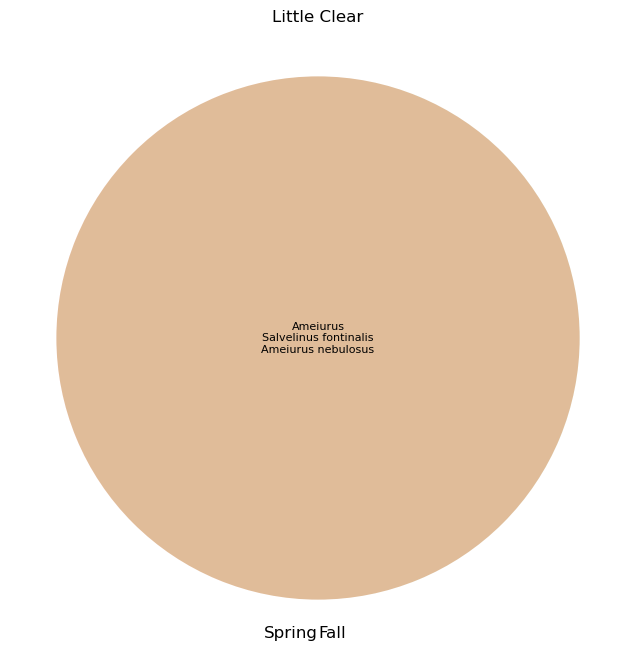

/fs/s6k/fast/scratch/8805813_noge4093_mpcs044/ipykernel_352704/2906622019.py:57: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  allyear["Classification"][spp] = "Year-round Resident"
/fs/s6k/fast/scratch/8805813_noge4093_mpcs044/ipykernel_352

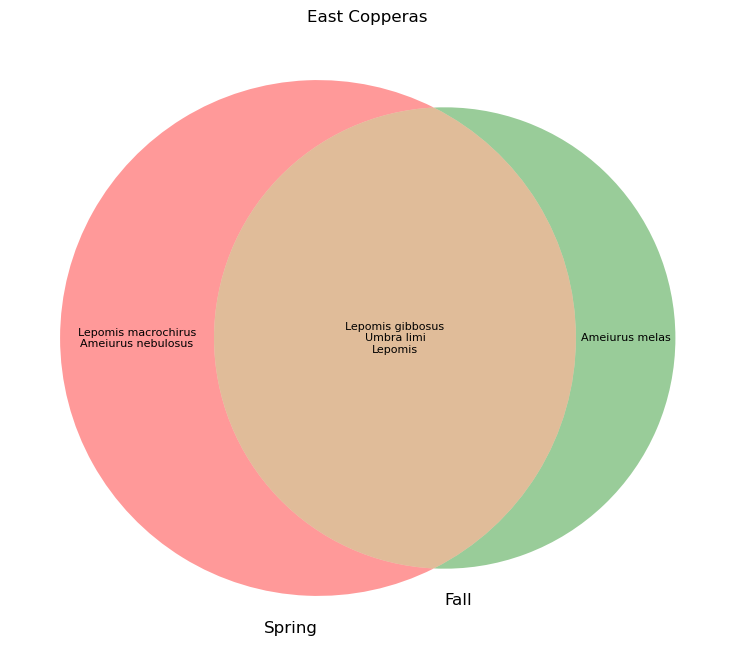

/fs/s6k/fast/scratch/8805813_noge4093_mpcs044/ipykernel_352704/2906622019.py:57: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  allyear["Classification"][spp] = "Year-round Resident"
/fs/s6k/fast/scratch/8805813_noge4093_mpcs044/ipykernel_352

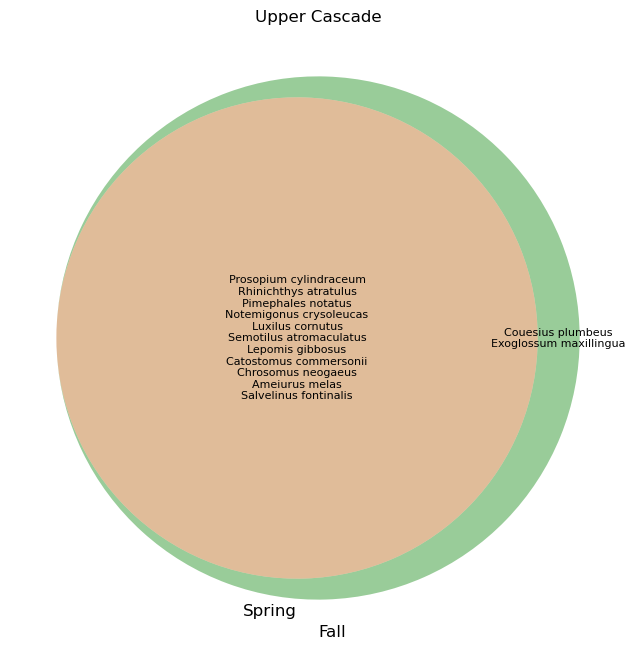

/fs/s6k/fast/scratch/8805813_noge4093_mpcs044/ipykernel_352704/2906622019.py:57: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  allyear["Classification"][spp] = "Year-round Resident"
/fs/s6k/fast/scratch/8805813_noge4093_mpcs044/ipykernel_352

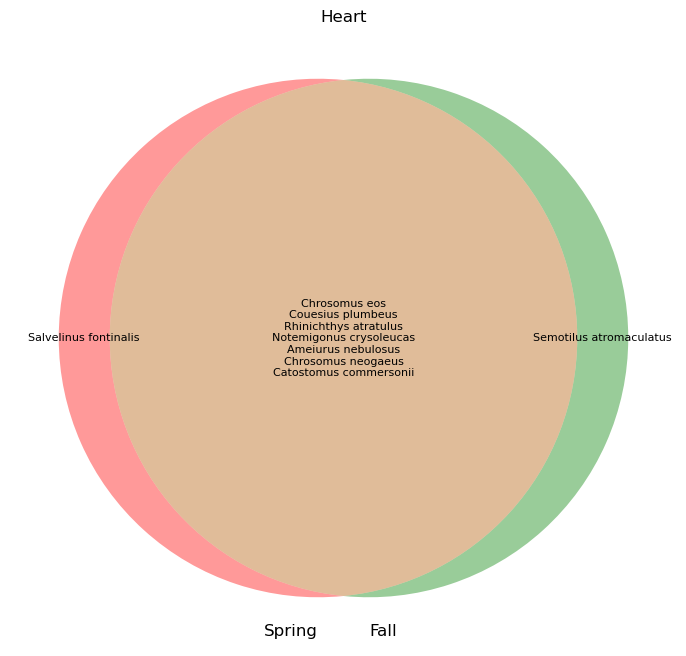

/fs/s6k/fast/scratch/8805813_noge4093_mpcs044/ipykernel_352704/2906622019.py:57: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  allyear["Classification"][spp] = "Year-round Resident"
/fs/s6k/fast/scratch/8805813_noge4093_mpcs044/ipykernel_352

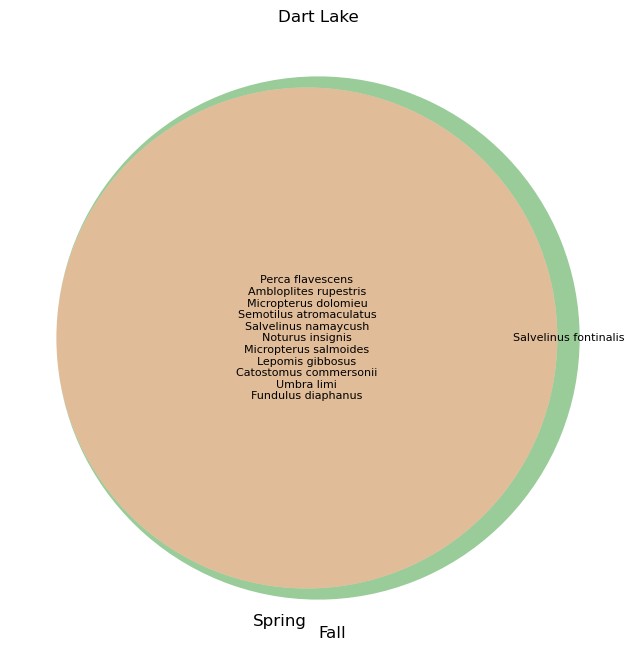

/fs/s6k/fast/scratch/8805813_noge4093_mpcs044/ipykernel_352704/2906622019.py:57: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  allyear["Classification"][spp] = "Year-round Resident"
/fs/s6k/fast/scratch/8805813_noge4093_mpcs044/ipykernel_352

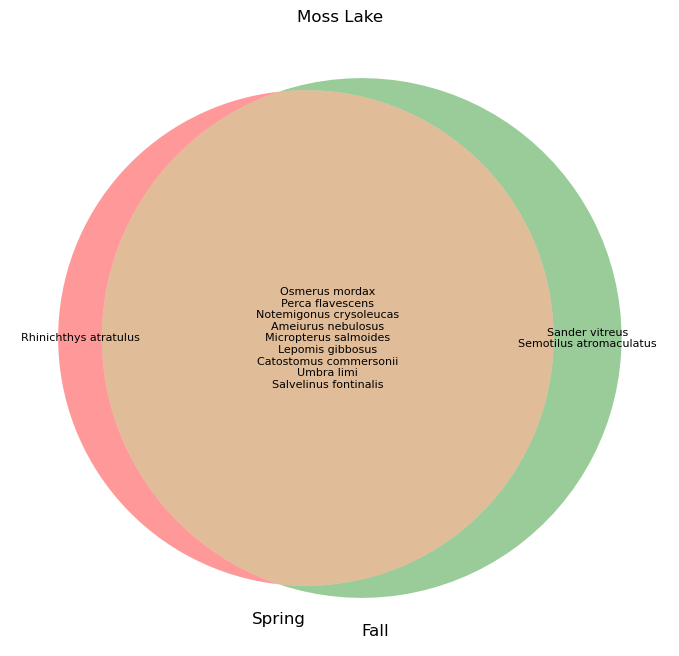

/fs/s6k/fast/scratch/8805813_noge4093_mpcs044/ipykernel_352704/2906622019.py:57: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  allyear["Classification"][spp] = "Year-round Resident"
/fs/s6k/fast/scratch/8805813_noge4093_mpcs044/ipykernel_352

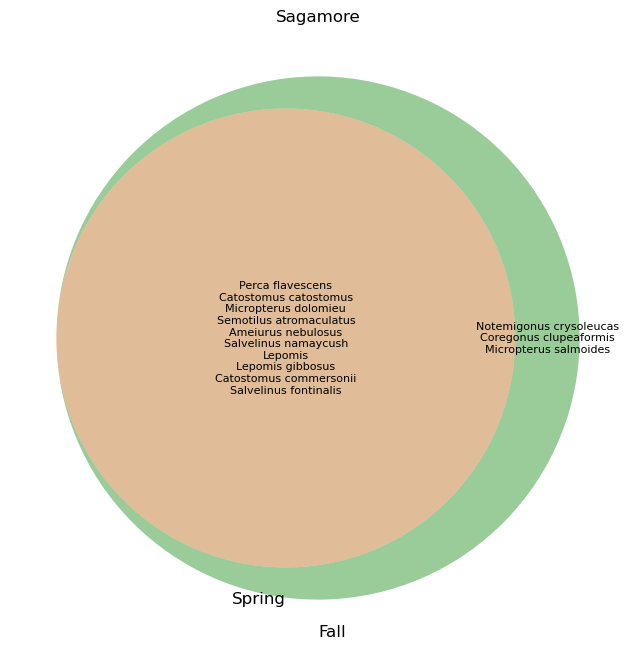

/fs/s6k/fast/scratch/8805813_noge4093_mpcs044/ipykernel_352704/2906622019.py:57: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  allyear["Classification"][spp] = "Year-round Resident"
/fs/s6k/fast/scratch/8805813_noge4093_mpcs044/ipykernel_352

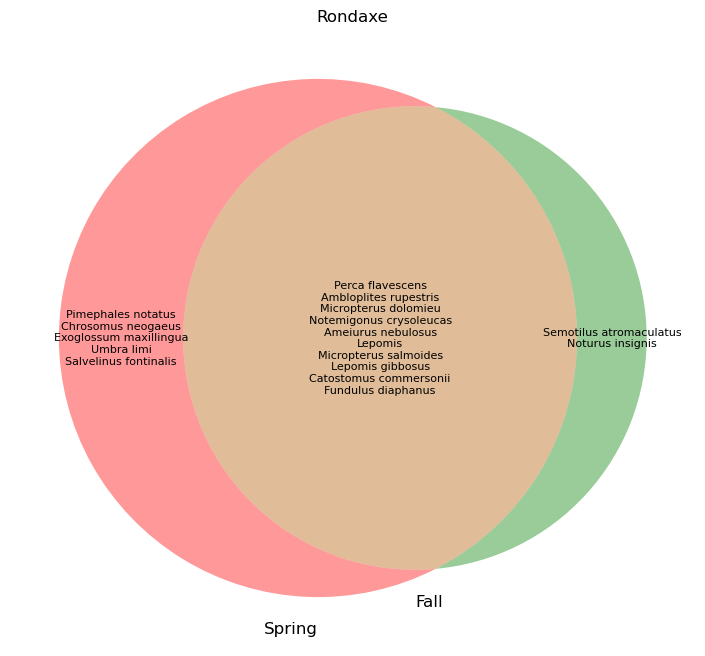

In [31]:
typeclassification = pd.DataFrame()
mifish = df_all_lakes.copy()
summary = pd.DataFrame()
filteredsamps = mifish.columns.tolist()
for site_season in ['Little Clear',
 'East Copperas',
 'Upper Cascade',
 'Heart',
 'Dart Lake',
 'Moss Lake',
 'Sagamore',
 'Rondaxe']:
    if len(metadata["Season"][metadata["Name"] == site_season].unique()) > 0:
        plt.figure(figsize=(10, 8))
        spring = (mifish[[i for i in metadata["EGCF-ID"]
              [metadata["Name"] == site_season]
              [metadata["Season"] == "Spring"].tolist() if i in filteredsamps] + 
                  ["Overall_Best"]])
        spring = spring[[i for i in spring.columns.tolist() if i not in df_group["EGCF-ID"][df_group['outlier_score'] > 2].tolist()]]
        spring["sum"] = spring[spring.columns[0:-1].tolist()].sum(axis=1, numeric_only=True)
        spring = spring[spring["sum"] > 0].reset_index(drop=True)
        springsplist = spring["Overall_Best"].tolist()
        
        fall = (mifish[[i for i in metadata["EGCF-ID"]
              [metadata["Name"] == site_season]
              [metadata["Season"] == "Early Fall"].tolist() if i in filteredsamps] + 
                  ["Overall_Best"]])
        fall = fall[[i for i in fall.columns.tolist() if i not in df_group["EGCF-ID"][df_group['outlier_score'] > 2].tolist()]]
        fall["sum"] = fall[fall.columns[0:-1].tolist()].sum(axis=1, numeric_only=True)
        fall = fall[fall["sum"] > 0].reset_index(drop=True)
        fallsplist = fall["Overall_Best"].tolist()
        
        springsplist = set(springsplist)
        fallsplist = set(fallsplist)
        
        allyear = (mifish[[i for i in metadata["EGCF-ID"]
              [metadata["Name"] == site_season] if i in filteredsamps] + 
                  ["Overall_Best"]])
        allyear = allyear[[i for i in allyear.columns.tolist() if i not in df_group["EGCF-ID"][df_group['outlier_score'] > 2].tolist()]]
        allyear["sum"] = allyear[allyear.columns[0:-1].tolist()].sum(axis=1, numeric_only=True)
        allyear = allyear[allyear["sum"] > 0].reset_index(drop=True)
        allyear["nsites"] = allyear[allyear.columns[0:-2].tolist()].gt(0).sum(axis=1)
        allyearsplist = allyear["Overall_Best"].tolist()
        allyear["Classification"] = "Unclassified"
        for spp in range(len(allyear)):
            if allyear["nsites"][spp] == 1:
                if allyear["Overall_Best"][spp] in fallsplist:
                    allyear["Classification"][spp] = "Fall Ephemeral"
                if allyear["Overall_Best"][spp] in springsplist:
                    allyear["Classification"][spp] = "Spring Ephemeral"
            elif allyear["nsites"][spp] > 1:
                if allyear["Overall_Best"][spp] in (fallsplist - springsplist):
                    allyear["Classification"][spp] = "Fall Resident"
                if allyear["Overall_Best"][spp] in (springsplist - fallsplist):
                    allyear["Classification"][spp] = "Spring Resident"
                if allyear["Overall_Best"][spp] in (fallsplist & springsplist):
                    allyear["Classification"][spp] = "Year-round Resident"
            if allyear["nsites"][spp] <= (0.1* len(metadata[metadata["Name"] == site_season])):
                if allyear["Overall_Best"][spp] in (fallsplist & springsplist):
                    allyear["Classification"][spp] = "Rare Year-round Resident"
        tmp = allyear[['Overall_Best', 'sum', 'nsites', 'Classification']]
        tmp["Lake"] = site_season
        tmp7 = pd.DataFrame(data = [len(springsplist - fallsplist), len(fallsplist - springsplist), len(fallsplist & springsplist)]).T
        tmp7.columns = ["springonly", "fallonly", "intersect"]
        tmp7["lake"] = site_season
        summary = pd.concat([summary, tmp7]).reset_index(drop=True)
        typeclassification = pd.concat([typeclassification, tmp]).reset_index(drop=True)
                # Define your species sets for three habitats
        # Plot the Venn diagram
        venn = venn2([springsplist, 
                      fallsplist], 
                     ('Spring', 'Fall'))

        # Now manually set the labels for each subset
        # The subsets are labeled by region IDs, like '100', '010', '001', '110', etc.
        try:   # Example for region '100' (only in A)
            venn.get_label_by_id('10').set_text('\n'.join(springsplist - fallsplist))
        except:
            pass
        try:
            venn.get_label_by_id('01').set_text('\n'.join(fallsplist - springsplist))
        except:
            pass
        try:
            venn.get_label_by_id('11').set_text('\n'.join(fallsplist & springsplist))
        except:
            pass
        for subset in ('10', '01', '11'):
            label = venn.get_label_by_id(subset)
            if label:  # Some regions may be empty
                label.set_fontsize(8)

        plt.title(site_season)
        plt.show()

In [32]:
summary["total"] = summary["springonly"] + summary["fallonly"] + summary["intersect"] 
summary["springpercent"] = summary["springonly"] / summary["total"]
summary["fallpercent"] = summary["fallonly"] / summary["total"]
summary["intersectpercent"] = summary["intersect"] / summary["total"]

In [33]:
typeclassification = (typeclassification
                      [typeclassification["Overall_Best"] != "Lepomis"].reset_index(drop=True))

In [34]:
size_migration = pd.DataFrame()
for i in typeclassification["Lake"].unique().tolist():
    tmp = pd.DataFrame(data = [i, (len(typeclassification[typeclassification["Lake"] == i]
                  [typeclassification["Classification"] == "Year-round Resident"]) / 
              len(typeclassification[typeclassification["Lake"] == i]))]).T
    tmp.columns = ["Name", "Percentage Resident"]
    size_migration = pd.concat([tmp, size_migration]).reset_index(drop=True)

/fs/s6k/fast/scratch/8805813_noge4093_mpcs044/ipykernel_352704/2228096954.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tmp = pd.DataFrame(data = [i, (len(typeclassification[typeclassification["Lake"] == i]
/fs/s6k/fast/scratch/8805813_noge4093_mpcs044/ipykernel_352704/2228096954.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tmp = pd.DataFrame(data = [i, (len(typeclassification[typeclassification["Lake"] == i]
/fs/s6k/fast/scratch/8805813_noge4093_mpcs044/ipykernel_352704/2228096954.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tmp = pd.DataFrame(data = [i, (len(typeclassification[typeclassification["Lake"] == i]
/fs/s6k/fast/scratch/8805813_noge4093_mpcs044/ipykernel_352704/2228096954.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tmp = pd.DataFrame(data = [i, (len(typeclassification[typeclassification["Lake"] == i]
/fs/s6k/fast/scratch

In [35]:
edna_spp = typeclassification.copy()
edna_spp.columns = ["Species", "Reads", "Nsites", "Classification", "Name"]
edna_spp["Year"] = 2023

In [36]:
new_spp_list = pd.concat([historical_spp, edna_spp]).reset_index(drop=True)
new_spp_list.loc[new_spp_list["Classification"].isna(), "Classification"] = "Catch"
new_spp_list["sort"] = np.nan
new_spp_list.loc[new_spp_list["Classification"] == "Catch", "sort"] = 0
new_spp_list.loc[new_spp_list["Classification"] == "Year-round Resident", "sort"] = 6
new_spp_list.loc[new_spp_list["Classification"] == "Rare Year-round Resident", "sort"] = 5
new_spp_list.loc[new_spp_list["Classification"] == 'Spring Resident', "sort"] = 4
new_spp_list.loc[new_spp_list["Classification"] == 'Spring Ephemeral', "sort"] = 3
new_spp_list.loc[new_spp_list["Classification"] == "Fall Resident", "sort"] = 2
new_spp_list.loc[new_spp_list["Classification"] == "Fall Ephemeral", "sort"] = 1
new_spp_list.loc[new_spp_list["Surveyor"] == "AFRP", "Year"] = 2022
new_spp_list = new_spp_list.loc[new_spp_list["Species"] != "Ameirus"].reset_index(drop=True)
new_spp_list.loc[new_spp_list["Species"] == "Coregonus", "Species"] = "Coregonus clupeaformis"
new_spp_list.loc[new_spp_list["Species"] == "Cottidae", "Species"] = "Cottus cognatus"
new_spp_list.loc[new_spp_list["Species"] == "Luxilus", "Species"] = "Luxilus cornatus"

In [37]:
new_spp_list = new_spp_list.drop_duplicates(["Name", "Year", "Species"]).reset_index(drop=True)

In [38]:
df = new_spp_list.sort_values("sort").reset_index(drop=True).copy()
# Define your categorical confidence levels and their order
confidence_levels = ['Catch', 
 'Year-round Resident',
 'Rare Year-round Resident',
 'Spring Resident',
 'Spring Ephemeral',
 'Fall Resident',
 'Fall Ephemeral'
]

# Map confidence levels to integers
confidence_map = {level: i for i, level in enumerate(confidence_levels)}
df['confidence_num'] = df['Classification'].map(confidence_map)

In [39]:
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.colors as mcolors

# Define colors
grey_color = "#5c5c5c"  # Grey for -1 < x < 0
start_color = "#305b37"
end_color = "#305b37"

# Create a segmented colormap
cmap = LinearSegmentedColormap.from_list(
    "custom_cmap",
    [(0, grey_color), (0.5, grey_color), (0.5, start_color), (1, end_color)]
)

In [40]:
df["Fraction"] = np.nan
for i in df.Name.unique().tolist():
    df.loc[(df["Name"] == i) & (df["Classification"] != "Catch"), "Fraction"] = df["Nsites"] / df["Nsites"][df["Name"] == i][df["Classification"] != "Catch"].max()

In [41]:
df.loc[df["Fraction"].isna(), "Fraction"] = -1

ValueError: The number of FixedLocator locations (1), usually from a call to set_ticks, does not match the number of labels (2).

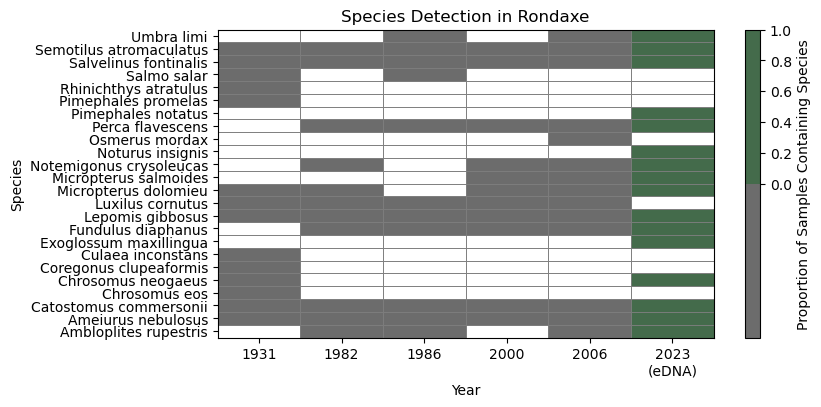

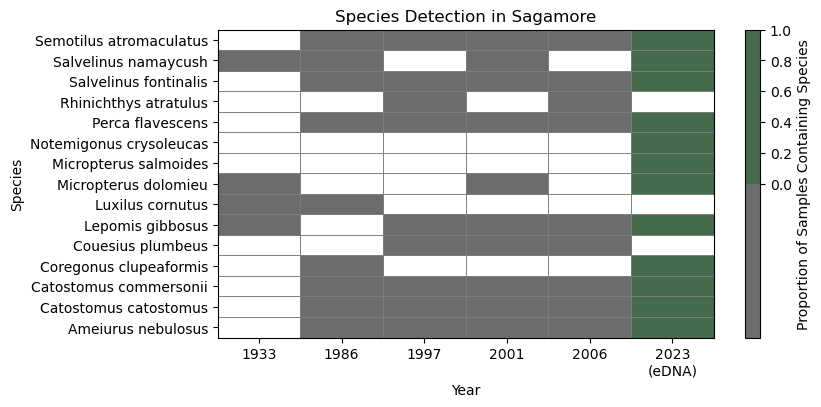

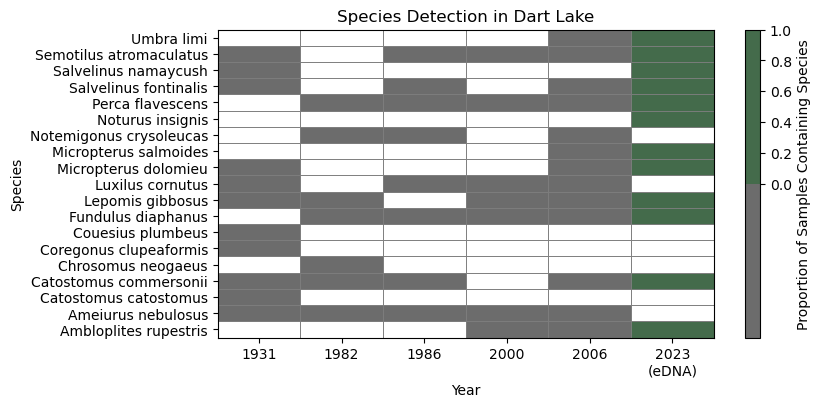

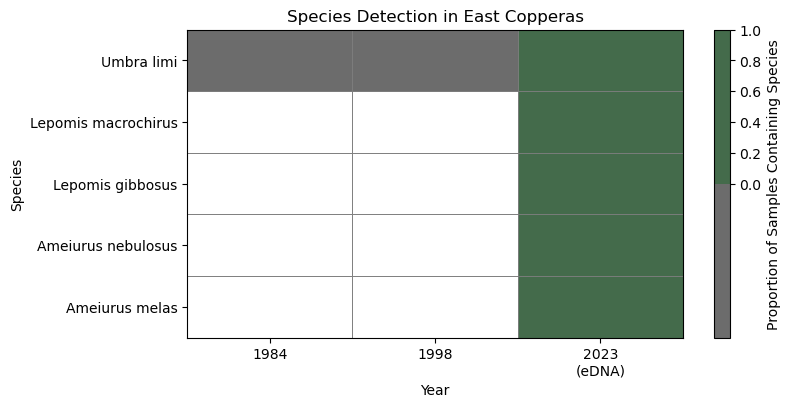

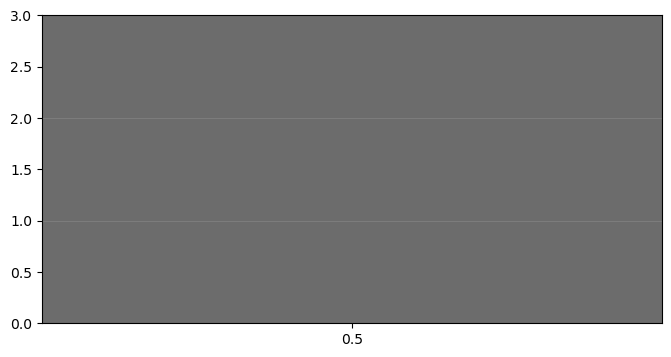

In [42]:
for lake_name in df.Name.unique():
    # Now create a pivot table: species as rows, years as columns, values as confidence category numbers
    lake_df = df[df['Name'] == lake_name].sort_values(["Species", "Fraction"], ascending = [False, True]).reset_index(drop=True)

    pivot = lake_df.pivot(index='Species', columns='Year', values='Fraction')

    # Set normalization boundaries between each category
    bounds = np.arange(len(confidence_levels) + 1) - 0.5
    norm = BoundaryNorm(bounds, cmap.N)

    # Plot
    plt.figure(figsize=(8, 4))
    heatmap = plt.pcolormesh(pivot.values, cmap=cmap, edgecolors='gray',# norm=norm, 
                             linewidth=0.5, shading='auto', alpha = 0.9)

    # Set ticks and labels
    if lake_name in ['East Lake', 'Green Lake', 'Combs Lake', 'Little Moose Lake']:
        plt.xticks(ticks=np.arange(len(pivot.columns)) + 0.5, labels=["Prior to 2023", "2023\n(eDNA)"])
    else:
        plt.xticks(ticks=np.arange(len(pivot.columns)) + 0.5, labels=pivot.columns.tolist()[0:-1] + ["2023\n(eDNA)"])
    plt.yticks(ticks=np.arange(len(pivot.index)) + 0.5, labels=pivot.index)
    plt.title(f'Species Detection in {lake_name}')
    plt.xlabel('Year')
    plt.ylabel('Species')

    # Add a colorbar with confidence levels
    cbar = plt.colorbar(heatmap)
    cbar.set_label('Proportion of Samples Containing Species')
    cbar.set_ticks([0, 0.2, 0.4, 0.6, 0.8, 1])
    plt.savefig("../" + lake_name + "_change_nsamples_color.pdf", dpi = 300,bbox_inches='tight')
    plt.savefig("../" + lake_name + "_change_nsamples_color.jpg", dpi = 300,bbox_inches='tight')

ValueError: The number of FixedLocator locations (1), usually from a call to set_ticks, does not match the number of labels (2).

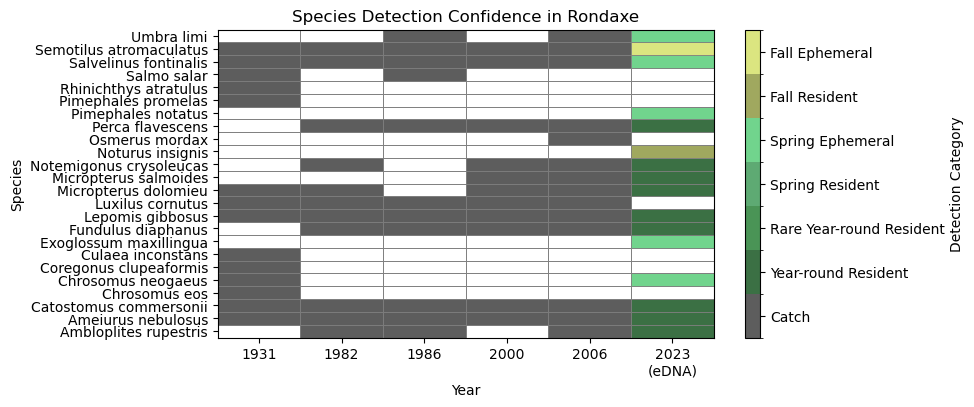

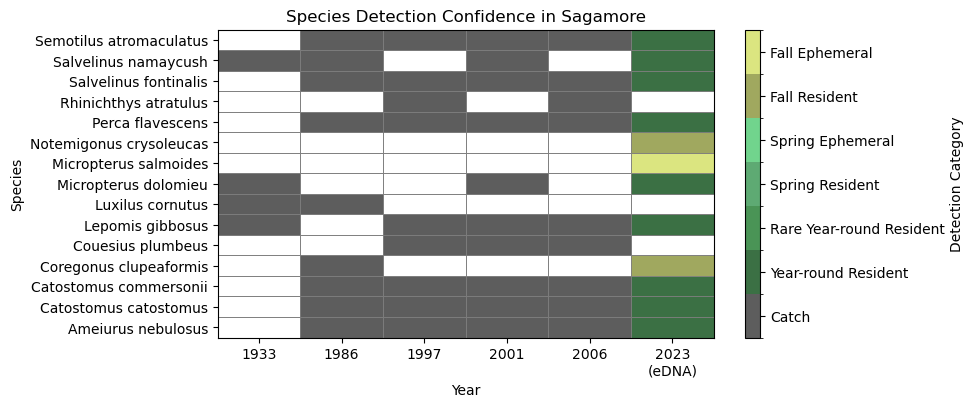

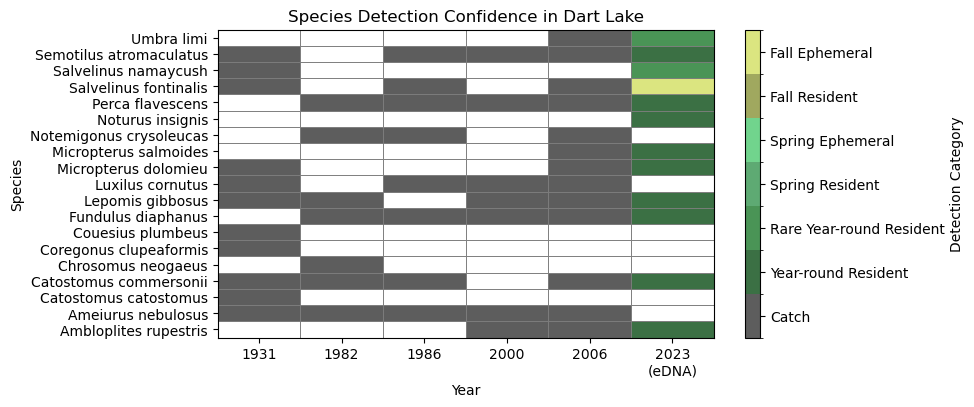

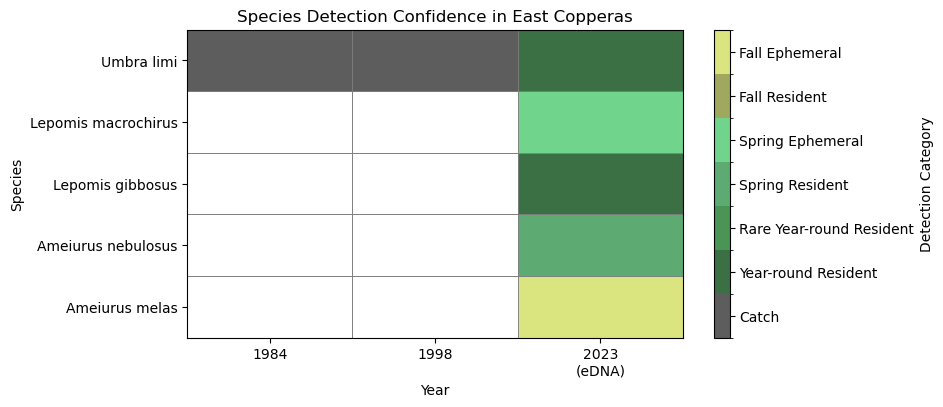

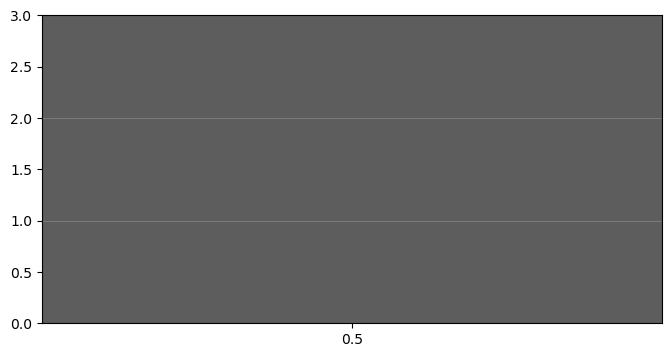

In [46]:
for lake_name in df.Name.unique():
    # Now create a pivot table: species as rows, years as columns, values as confidence category numbers
    lake_df = df[df['Name'] == lake_name].sort_values(["Species", "confidence_num"], ascending = [False, True]).reset_index(drop=True)

    pivot = lake_df.pivot(index='Species', columns='Year', values='confidence_num')

    # Create a color palette for the confidence levels
    colors = ['#4B4B4B',  # Dark grey
              '#25602f',  # Dark summery green
              '#368944', # light
              '#4ca164',  # dark spring
              '#62d081',  # light spring
              '#969f4d',  # dark fall
              '#d7e372']  # light fall
    cmap = ListedColormap(colors)

    # Set normalization boundaries between each category
    bounds = np.arange(len(confidence_levels) + 1) - 0.5
    norm = BoundaryNorm(bounds, cmap.N)

    # Plot
    plt.figure(figsize=(8, 4))
    heatmap = plt.pcolormesh(pivot.values, cmap=cmap, norm=norm, edgecolors='gray', 
                             linewidth=0.5, shading='auto', alpha = 0.9)

    # Set ticks and labels
    if lake_name in ['East Lake', 'Green Lake', 'Combs Lake', 'Little Moose Lake']:
        plt.xticks(ticks=np.arange(len(pivot.columns)) + 0.5, labels=["Prior to 2023", "2023\n(eDNA)"])
    else:
        plt.xticks(ticks=np.arange(len(pivot.columns)) + 0.5, labels=pivot.columns.tolist()[0:-1] + ["2023\n(eDNA)"])
    plt.yticks(ticks=np.arange(len(pivot.index)) + 0.5, labels=pivot.index)
    plt.title(f'Species Detection Confidence in {lake_name}')
    plt.xlabel('Year')
    plt.ylabel('Species')

    # Add a colorbar with confidence levels
    cbar = plt.colorbar(heatmap, ticks=range(len(confidence_levels)))
    cbar.ax.set_yticklabels(confidence_levels)
    cbar.set_label('Detection Category')

    plt.savefig("../" + lake_name + "_change.pdf", dpi = 300)

In [49]:
modern = df[df["Reads"].notna()]

In [50]:
modern = modern.drop_duplicates(["Name", "Species"]).reset_index(drop=True).sort_values("Name").reset_index(drop=True)

In [51]:
old = df[df["Reads"].isna()][df["Year"] == 2006].reset_index(drop=True)

/fs/s6k/fast/scratch/8805813_noge4093_mpcs044/ipykernel_352704/2488974983.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  old = df[df["Reads"].isna()][df["Year"] == 2006].reset_index(drop=True)


In [52]:
old = old.drop_duplicates(["Name", "Species"]).reset_index(drop=True).sort_values("Name").reset_index(drop=True)

In [53]:
alltimes = df[df["Year"] > 2005].drop_duplicates(["Name", "Species"]).reset_index(drop=True).sort_values("Name").reset_index(drop=True)

In [54]:
alltimes["Detection"] = np.nan
for i in range(len(alltimes)):
    tmp1 = modern[modern["Name"] == alltimes["Name"][i]][modern["Species"] == alltimes["Species"][i]].reset_index(drop=True)
    tmp2 = old[old["Name"] == alltimes["Name"][i]][old["Species"] == alltimes["Species"][i]].reset_index(drop=True)
    if ((len(tmp1) > 0) and (len(tmp2) > 0)):
        alltimes["Detection"][i] = "Detected by both catch and eDNA"
    elif ((len(tmp2) == 0) and (len(tmp1) > 0)):
        alltimes["Detection"][i] = "Detected only by eDNA"
    elif ((len(tmp1) == 0) and (len(tmp2) > 0)):
        alltimes["Detection"][i] = "Detected only by catch"

/fs/s6k/fast/scratch/8805813_noge4093_mpcs044/ipykernel_352704/2892855699.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tmp1 = modern[modern["Name"] == alltimes["Name"][i]][modern["Species"] == alltimes["Species"][i]].reset_index(drop=True)
/fs/s6k/fast/scratch/8805813_noge4093_mpcs044/ipykernel_352704/2892855699.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tmp2 = old[old["Name"] == alltimes["Name"][i]][old["Species"] == alltimes["Species"][i]].reset_index(drop=True)
/fs/s6k/fast/scratch/8805813_noge4093_mpcs044/ipykernel_352704/2892855699.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tmp1 = modern[modern["Name"] == alltimes["Name"][i]][modern["Species"] == alltimes["Species"][i]].reset_index(drop=True)
/fs/s6k/fast/scratch/8805813_noge4093_mpcs044/ipykernel_352704/2892855699.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tmp2 = old[old

/fs/s6k/fast/scratch/8805813_noge4093_mpcs044/ipykernel_352704/2945042179.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


<Figure size 640x480 with 0 Axes>

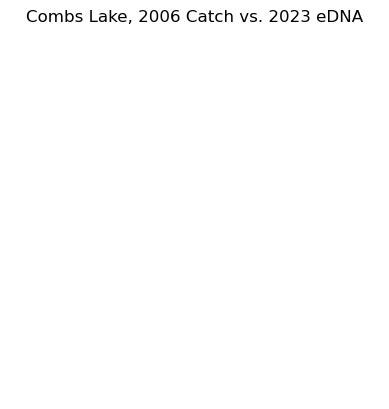

<Figure size 640x480 with 0 Axes>

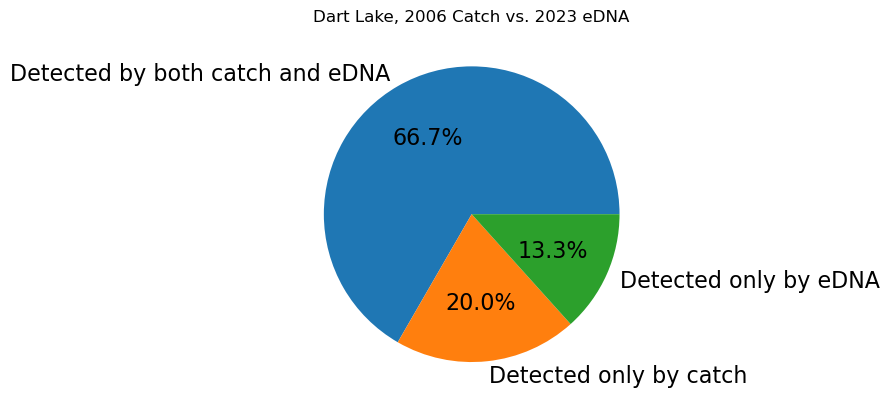

<Figure size 640x480 with 0 Axes>

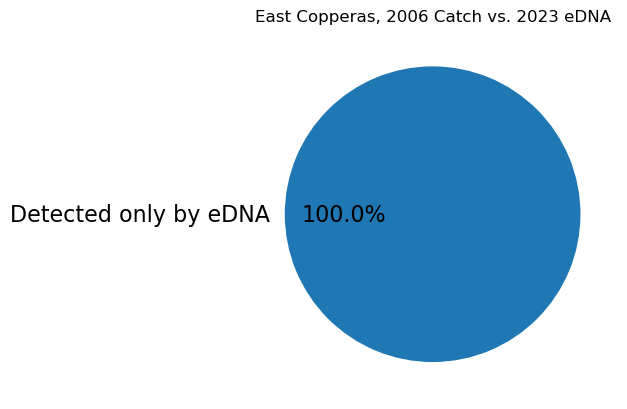

<Figure size 640x480 with 0 Axes>

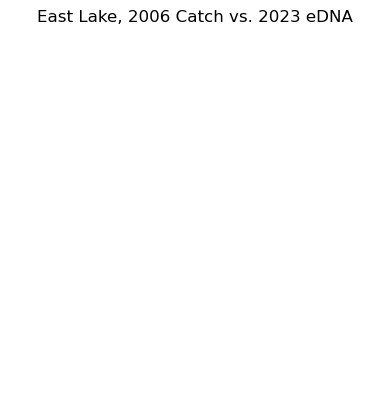

<Figure size 640x480 with 0 Axes>

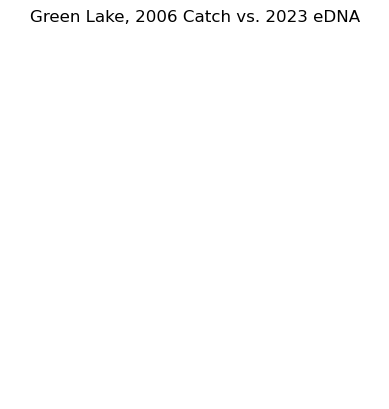

<Figure size 640x480 with 0 Axes>

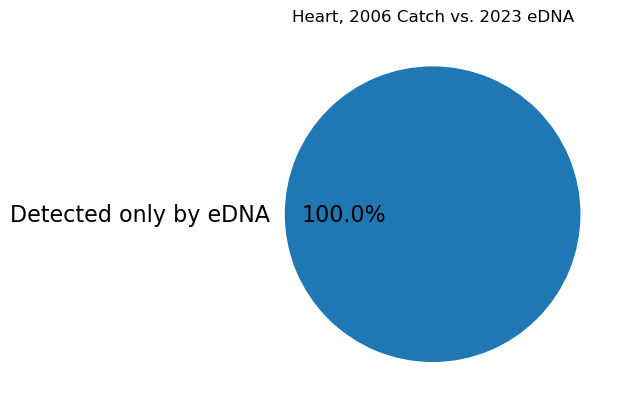

<Figure size 640x480 with 0 Axes>

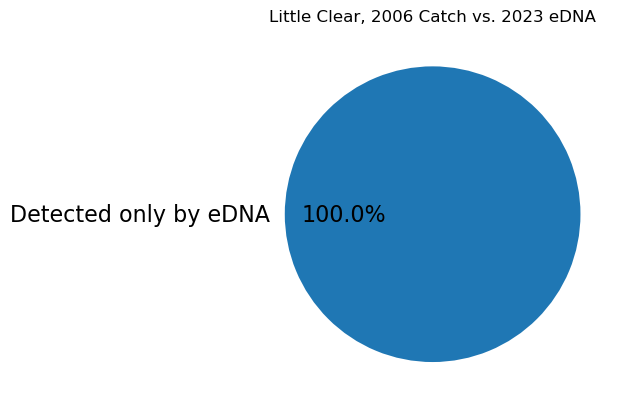

<Figure size 640x480 with 0 Axes>

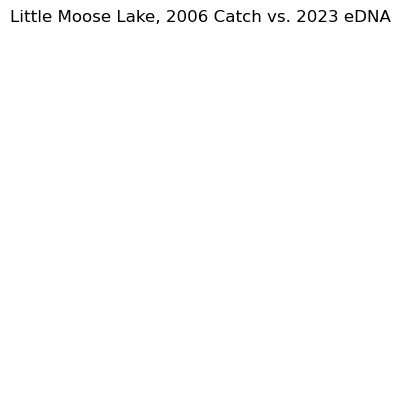

<Figure size 640x480 with 0 Axes>

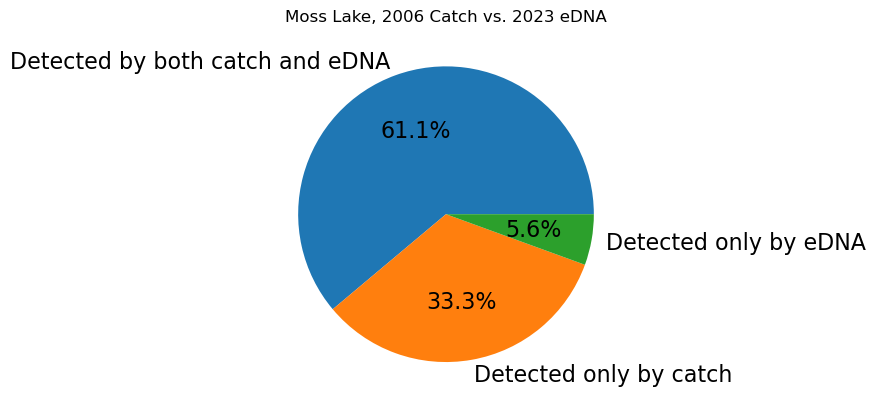

<Figure size 640x480 with 0 Axes>

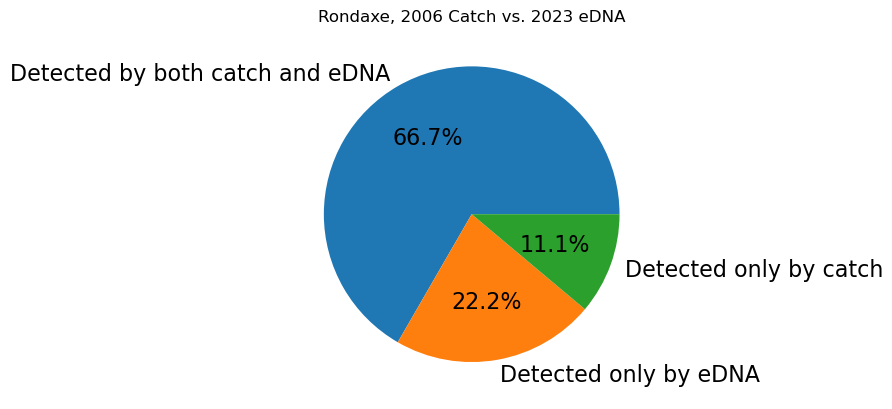

<Figure size 640x480 with 0 Axes>

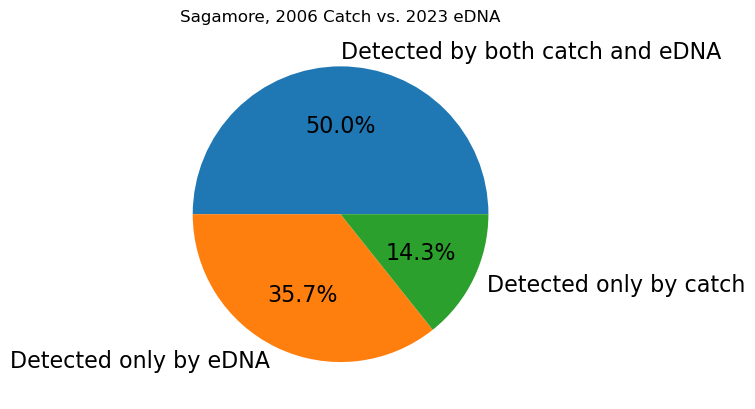

<Figure size 640x480 with 0 Axes>

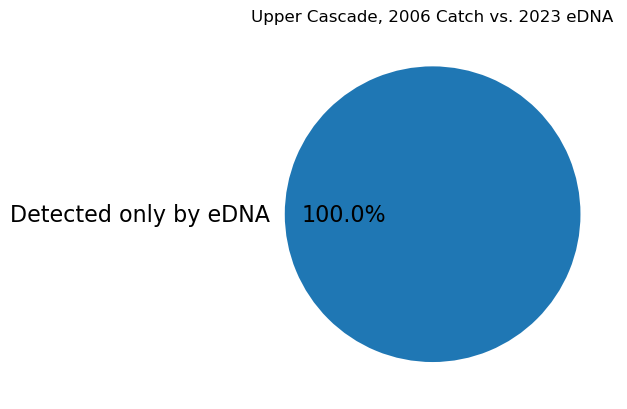

In [55]:
for i in alltimes.Name.unique().tolist():
    tmp = pd.DataFrame(alltimes[alltimes["Name"] == i].value_counts("Detection")).reset_index(drop=False)
    plt.figure()
    labels = tmp["Detection"].tolist()
    sizes = tmp["count"].tolist()
    fig, ax = plt.subplots()
    ax.pie(sizes, labels=labels, autopct='%1.1f%%', textprops={'fontsize': 16})
    plt.title(i + ", 2006 Catch vs. 2023 eDNA")

In [56]:
lakemeta = size_migration.merge(pd.read_csv("../lake_metadata.csv"), how = "left", on = "Name")
lakemeta["Percentage Resident"] = lakemeta["Percentage Resident"].astype(float)

In [57]:
corrdata = lakemeta[["Name", 'Invert_Family_Richness', 'thermo_depth', "thermo_temp",
       'depth.5mgL', 'temp.5mgL', 'min_do', 'sechi.depth', 'Flushing Rate (times/yr)', 'Shoreline Length (km)',
       'Littoral Area (ha)', 'surface_area (ha)', "Percentage Resident"]].drop_duplicates(["Name"])

In [58]:
corrdata = corrdata[['Invert_Family_Richness', 'thermo_depth', "thermo_temp",
       'depth.5mgL', 'temp.5mgL', 'min_do', 'sechi.depth', 'Flushing Rate (times/yr)', 'Shoreline Length (km)',
       'Littoral Area (ha)', 'surface_area (ha)', "Percentage Resident"]]

In [59]:
corr = corrdata.corr()

Text(0.5, 1.0, 'Correlation Matrix - Lake characteristics and percentage of resident species')

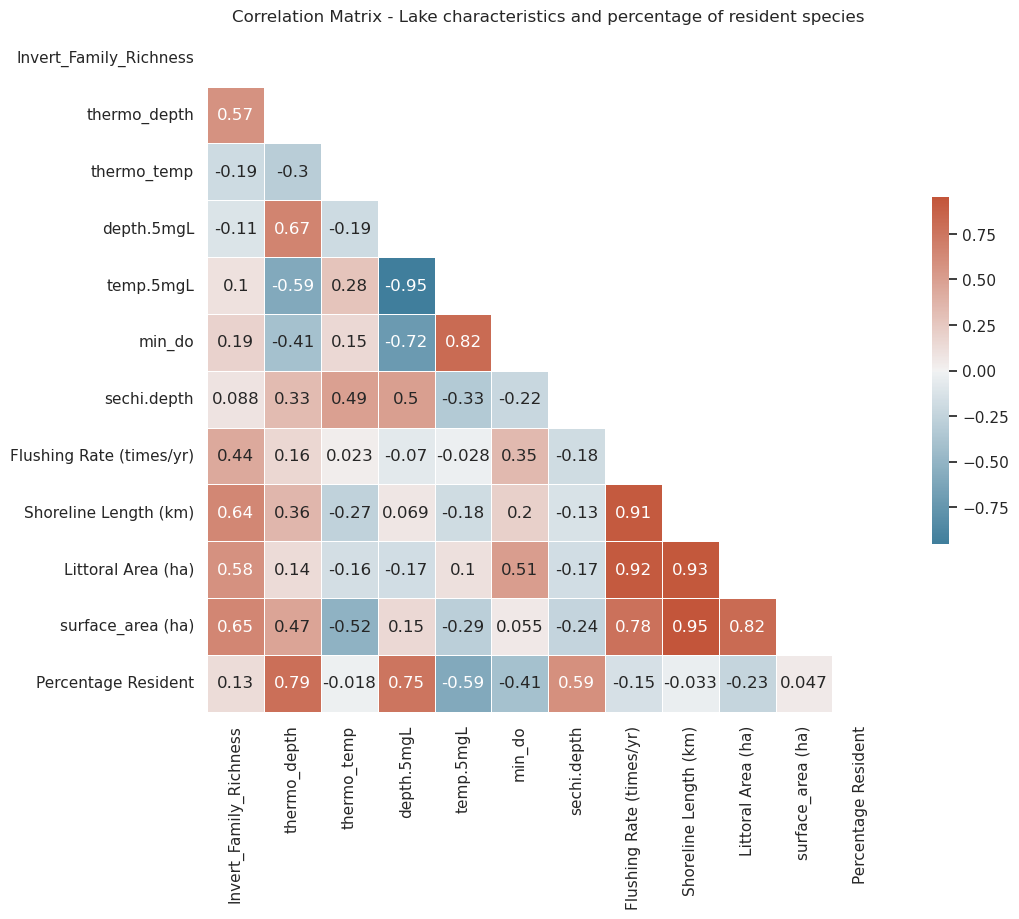

In [60]:
sns.set_theme(style="white")
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)
plt.title("Correlation Matrix - Lake characteristics and percentage of resident species")

In [61]:
df_all_lakes[["Overall_Best"]].to_csv("../outlier_removed_fishlist.txt", sep = "\t", index = False)

In [62]:
metadata.loc[metadata["Description"] == "Near Shore", "Description"] = "Nearshore"

In [63]:
species_habitat = pd.read_csv("../ALS_fishcodes_with_latin_names.csv")
species_habitat.loc[species_habitat["Latin Name"].str.contains("Coregonus"), "Latin Name"] = "Coregonus"
species_habitat = species_habitat[species_habitat["habitat"].notna()].reset_index(drop=True)

In [64]:
offshore = pd.DataFrame()
filteredsamps = df_all_lakes.columns.tolist()
for merge in (metadata["Merged"]
              [~metadata["Site"].isin(["PCR Blank", "Blank", "Extraction Blank"])]
              [metadata["Merged"].notna()].unique().tolist()):
    lake = merge.split("_")[0]
    season = merge.split("_")[1]
    tmp = (df_all_lakes[[i for i in metadata["EGCF-ID"]
                  [metadata["Name"] == lake][metadata["Description"].isin(["Deep", "Surface"])]
                  [metadata["Season"] == season].tolist() if i in filteredsamps] + 
                  ["Overall_Best", "Overall_Best_Taxonomic_Level", "Genus", "Family"]]
           [df_all_lakes["Overall_Best_Taxonomic_Level"] == "Species"]).fillna(0).reset_index(drop=True)
    tmp = tmp[[i for i in tmp.columns.tolist() if i not in df_group["EGCF-ID"][df_group['outlier_score'] > 2].tolist()]]
    tmp['sum'] = tmp.sum(axis=1, numeric_only=True)
    tmp = tmp[tmp["sum"] > 0].reset_index(drop=True)
    tmp = tmp[tmp.columns.tolist()[:-4]].set_index("Overall_Best").T
    tmp = tmp[[sp for sp in species_habitat["Latin Name"][species_habitat["habitat"].str.contains("offshore")].tolist() if sp in tmp.columns.tolist()]]
    shuffles = []
    try:
        for shuff in list(range(0,1000)):
            tmp1 = tmp.copy()
            for tax in tmp.columns:
                tmp1[tax] = np.random.permutation(tmp[tax].values)
            for nsamps in list(range(1, len(tmp) + 1)):
                shuffles = shuffles + [[tmp1.sample(nsamps).agg({'sum'}).astype(bool).sum(axis=1).reset_index(drop=True)[0], nsamps]]
        shuffles = pd.DataFrame(shuffles, columns = ["Number of Species", "Number of Samples"])
        shuffles["Name"] = lake
        shuffles["Season"] = season
        offshore = pd.concat([offshore, shuffles]).reset_index(drop=True)
    except:
        pass

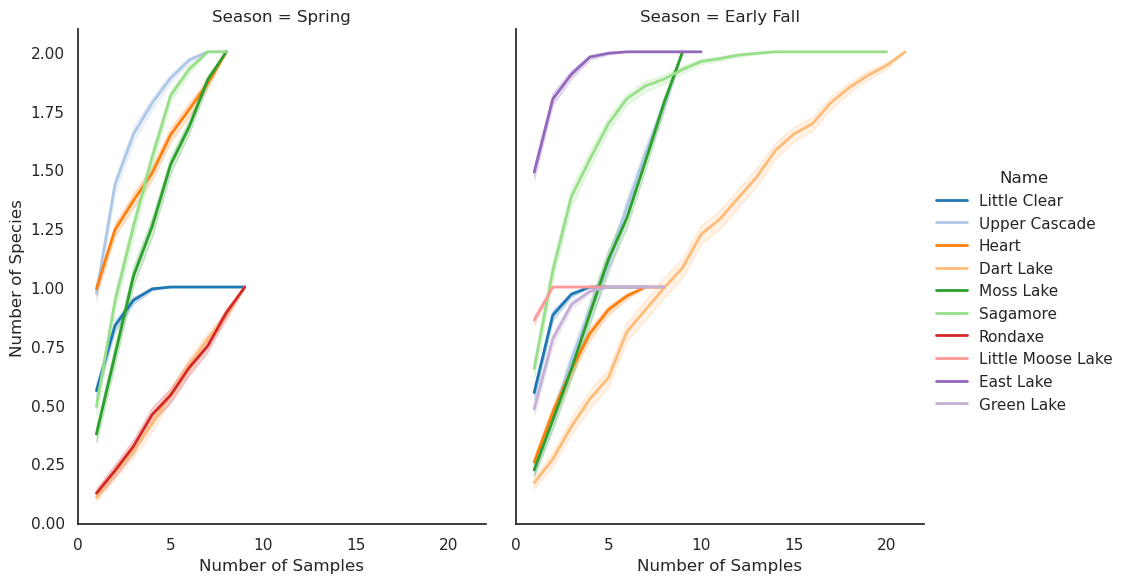

In [65]:
g = sns.FacetGrid(offshore.reset_index(drop=True),
                  col="Season", hue = "Name", palette = "tab20", height=6, aspect=0.8)

# Map a scatterplot to the grid
g.map_dataframe(sns.lineplot, x = "Number of Samples", y = "Number of Species", lw = 2)
g.add_legend()

In [66]:
deep = pd.DataFrame()
filteredsamps = df_all_lakes.columns.tolist()
for merge in (metadata["Merged"]
              [~metadata["Site"].isin(["PCR Blank", "Blank", "Extraction Blank"])]
              [metadata["Merged"].notna()].unique().tolist()):
    lake = merge.split("_")[0]
    season = merge.split("_")[1]
    tmp = (df_all_lakes[[i for i in metadata["EGCF-ID"]
                  [metadata["Name"] == lake][metadata["Description"].isin(["Deep"])]
                  [metadata["Season"] == season].tolist() if i in filteredsamps] + 
                  ["Overall_Best", "Overall_Best_Taxonomic_Level", "Genus", "Family"]]
           [df_all_lakes["Overall_Best_Taxonomic_Level"] == "Species"]).fillna(0).reset_index(drop=True)
    tmp = tmp[[i for i in tmp.columns.tolist() if i not in df_group["EGCF-ID"][df_group['outlier_score'] > 2].tolist()]]
    tmp['sum'] = tmp.sum(axis=1, numeric_only=True)
    tmp = tmp[tmp["sum"] > 0].reset_index(drop=True)
    tmp = tmp[tmp.columns.tolist()[:-4]].set_index("Overall_Best").T
    tmp = tmp[[sp for sp in species_habitat["Latin Name"][species_habitat["habitat"].str.contains("offshore deep")].tolist() if sp in tmp.columns.tolist()]]
    shuffles = []
    try:
        for shuff in list(range(0,1000)):
            tmp1 = tmp.copy()
            for tax in tmp.columns:
                tmp1[tax] = np.random.permutation(tmp[tax].values)
            for nsamps in list(range(1, len(tmp) + 1)):
                shuffles = shuffles + [[tmp1.sample(nsamps).agg({'sum'}).astype(bool).sum(axis=1).reset_index(drop=True)[0], nsamps]]
        shuffles = pd.DataFrame(shuffles, columns = ["Number of Species", "Number of Samples"])
        shuffles["Name"] = lake
        shuffles["Season"] = season
        deep = pd.concat([deep, shuffles]).reset_index(drop=True)
    except:
        pass

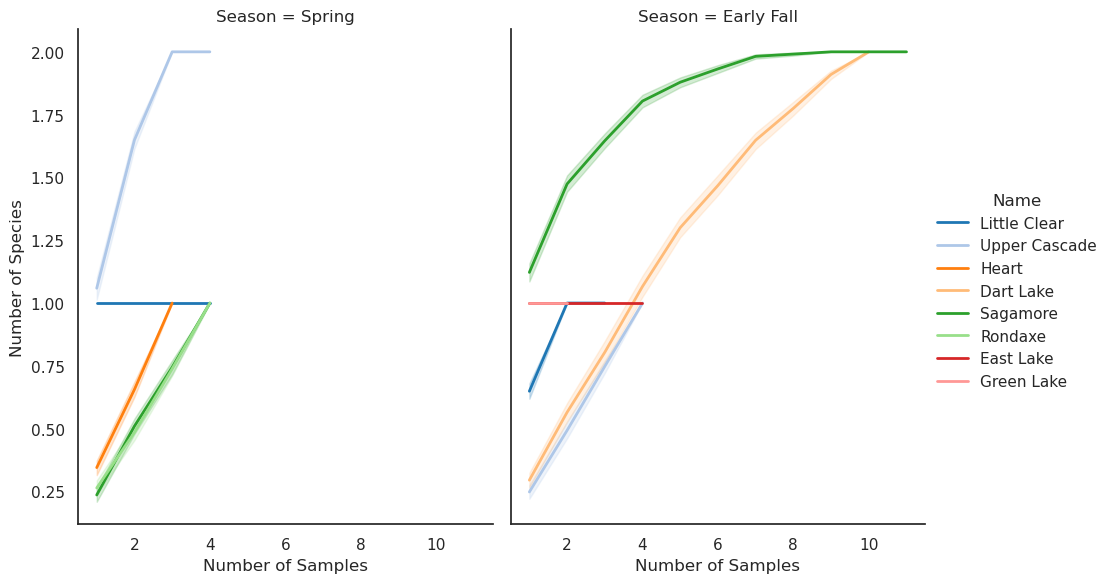

In [67]:
g = sns.FacetGrid(deep.reset_index(drop=True),
                  col="Season", hue = "Name", palette = "tab20", height=6, aspect=0.8)

# Map a scatterplot to the grid
g.map_dataframe(sns.lineplot, x = "Number of Samples", y = "Number of Species", lw = 2)
g.add_legend()

In [68]:
nearshore = pd.DataFrame()
filteredsamps = df_all_lakes.columns.tolist()
for merge in (metadata["Merged"]
              [~metadata["Site"].isin(["PCR Blank", "Blank", "Extraction Blank"])]
              [metadata["Merged"].notna()].unique().tolist()):
    lake = merge.split("_")[0]
    season = merge.split("_")[1]
    tmp = (df_all_lakes[[i for i in metadata["EGCF-ID"]
                  [metadata["Name"] == lake][metadata["Description"].isin(["Nearshore"])]
                  [metadata["Season"] == season].tolist() if i in filteredsamps] + 
                  ["Overall_Best", "Overall_Best_Taxonomic_Level", "Genus", "Family"]]
           [df_all_lakes["Overall_Best_Taxonomic_Level"] == "Species"]).fillna(0).reset_index(drop=True)
    tmp = tmp[[i for i in tmp.columns.tolist() if i not in df_group["EGCF-ID"][df_group['outlier_score'] > 2].tolist()]]
    tmp['sum'] = tmp.sum(axis=1, numeric_only=True)
    tmp = tmp[tmp["sum"] > 0].reset_index(drop=True)
    tmp = tmp[tmp.columns.tolist()[:-4]].set_index("Overall_Best").T
    tmp = tmp[[sp for sp in species_habitat["Latin Name"][species_habitat["habitat"].str.contains("nearshore")].tolist() if sp in tmp.columns.tolist()]]
    shuffles = []
    try:
        for shuff in list(range(0,1000)):
            tmp1 = tmp.copy()
            for tax in tmp.columns:
                tmp1[tax] = np.random.permutation(tmp[tax].values)
            for nsamps in list(range(1, len(tmp) + 1)):
                shuffles = shuffles + [[tmp1.sample(nsamps).agg({'sum'}).astype(bool).sum(axis=1).reset_index(drop=True)[0], nsamps]]
        shuffles = pd.DataFrame(shuffles, columns = ["Number of Species", "Number of Samples"])
        shuffles["Name"] = lake
        shuffles["Season"] = season
        nearshore = pd.concat([nearshore, shuffles]).reset_index(drop=True)
    except:
        pass

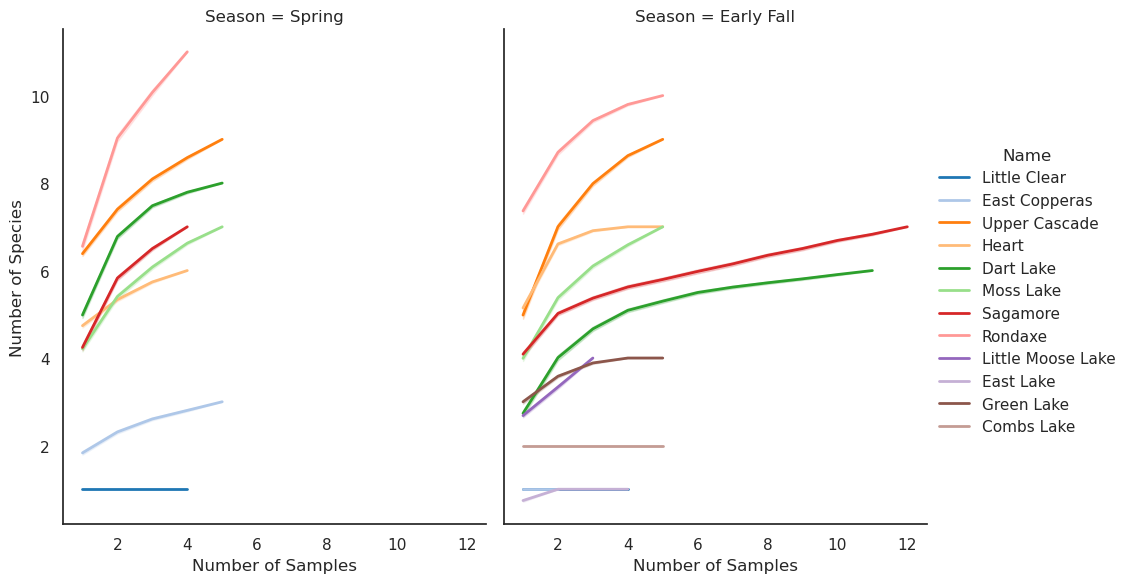

In [69]:
g = sns.FacetGrid(nearshore.reset_index(drop=True),
                  col="Season", hue = "Name", palette = "tab20", height=6, aspect=0.8)

# Map a scatterplot to the grid
g.map_dataframe(sns.lineplot, x = "Number of Samples", y = "Number of Species", lw = 2)
g.add_legend()

In [70]:
# Function to calculate RSS
def calculate_rss(y_data, y_model):
    return np.sum((y_data - y_model) ** 2)

# 1. Michaelis-Menten model (Basic)
def michaelis_menten(x, K, C, B):
    return (K * x) / (x + C)

# 2. Hill function model
def hill_function(x, K, C, n):
    return (K * x**n) / (C**n + x**n)

# 3. Generalized Logistic model
def generalized_logistic(x, K, B, C):
    return K / (1 + np.exp(-B * (x - C)))

# 4. Logistic Growth (Standard S-shaped curve)
def logistic_growth(x, K, r, x0):
    return K / (1 + np.exp(-r * (x - x0)))

# 5. Richards Curve (generalized logistic curve)
def richards(x, K, r, x0, v):
    return K / (1 + np.exp(-r * (x - x0)))**(1/v)

# 6. Gompertz Curve (asymptotic curve)
def gompertz(x, K, r, x0):
    return K * np.exp(-np.exp(-r * (x - x0)))

# 7. Exponential Decay (Inverted)
def exp_decay(x, A, B, C):
    return A * np.exp(-B * (x - C))

# 8. Shifted Logistic Growth (shifted S-curve)
def shifted_logistic(x, K, r, x0):
    return K / (1 + np.exp(-r * (x - x0)))

# 9. Exponential Growth Model (inverse of decay)
def exp_growth(x, A, r, C):
    return A * np.exp(r * (x - C))

# 10. Monod Equation (a variant of Michaelis-Menten)
def monod(x, K, S, B):
    return (K * x) / (S + x)

# 11. Humboldt Growth Curve (another biological growth model)
def humboldt_growth(x, K, r, x0):
    return K / (1 + np.exp(-r * (x - x0)))

# 12. Barton Curve (used in environmental sciences)
def barton_curve(x, A, B, C):
    return A / (1 + np.exp(-B * (x - C)))

models = {
    "Michaelis-Menten": michaelis_menten,
    "Hill": hill_function,
    "Generalized Logistic": generalized_logistic,
    "Logistic Growth": logistic_growth,
    "Richards": richards,
    "Gompertz": gompertz,
    "Exponential Decay": exp_decay,
    "Shifted Logistic": shifted_logistic,
    "Exponential Growth": exp_growth,
    "Monod": monod,
    "Humboldt Growth": humboldt_growth,
    "Barton Curve": barton_curve
}

# Initial parameter guesses for each model
initial_guesses = {
    "Michaelis-Menten": [50, 10, 2],
    "Hill": [50, 20, 2],
    "Generalized Logistic": [50, 0.1, 20],
    "Logistic Growth": [50, 0.1, 20],
    "Richards": [50, 0.1, 20, 1],
    "Gompertz": [50, 0.1, 20],
    "Exponential Decay": [50, 0.1, 10],
    "Shifted Logistic": [50, 0.1, 20],
    "Exponential Growth": [50, 0.1, 10],
    "Monod": [50, 20, 0.1],
    "Humboldt Growth": [50, 0.1, 20],
    "Barton Curve": [50, 0.1, 20]
}

model_bounds = {
    "Michaelis-Menten": ([0, -np.inf, -np.inf], [80, np.inf, np.inf]),
    "Hill": ([0, -np.inf, -np.inf], [80, np.inf, np.inf]),
    "Generalized Logistic": ([0, -np.inf, -np.inf], [80, np.inf, np.inf]),
    "Logistic Growth": ([0, -np.inf, -np.inf], [80, np.inf, np.inf]),
    "Richards": ([0, -np.inf, -np.inf, -np.inf], [80, np.inf, np.inf, np.inf]),
    "Gompertz": ([0, -np.inf, -np.inf], [80, np.inf, np.inf]),
    "Exponential Decay": ([0, -np.inf, -np.inf], [80, np.inf, np.inf]),
    "Shifted Logistic": ([0, -np.inf, -np.inf], [80, np.inf, np.inf]),
    "Exponential Growth": ([0, -np.inf, -np.inf], [80, np.inf, np.inf]),
    "Monod": ([0, -np.inf, -np.inf], [80, np.inf, np.inf]),
    "Humboldt Growth": ([0, -np.inf, -np.inf], [80, np.inf, np.inf]),
    "Barton Curve": ([0, -np.inf, -np.inf], [80, np.inf, np.inf])
}

In [71]:
offshore["Merged"] = offshore["Name"] + "_" + offshore["Season"]

In [72]:
lakes = offshore["Merged"].unique().tolist()

In [73]:
offshore = offshore.drop('Merged', axis=1) # Returns a new DataFrame

In [74]:
best_models_by_lake = {}
fitted_data = pd.DataFrame()
for lake in lakes:
    # Store results
    best_rss = np.inf
    best_curve = None
    best_params = None
    best_y_fit = None
    
    rawdata = (offshore[offshore["Name"] == lake.split("_")[0]]
           [offshore["Season"] == lake.split("_")[1]])
    rawdata = rawdata.groupby(["Name", "Season", "Number of Samples"]).mean().reset_index()
    x_data = np.append([0], np.array(rawdata["Number of Samples"]))
    y_data = np.append([0], np.array(rawdata["Number of Species"]))

    # Try fitting each curve type
    for curve_name in list(models.keys()):
        try:
            # Fit the curve
            popt, _ = curve_fit(models[curve_name], x_data, y_data, 
                                p0=initial_guesses[curve_name], 
                                bounds=model_bounds[curve_name],
                                maxfev=50000)

            # Calculate the fitted values
            y_fit = models[curve_name](x_data, *popt)

            # Calculate RSS
            rss = calculate_rss(y_data, y_fit)

            # Store the best model
            if rss < best_rss:
                best_rss = rss
                best_curve = curve_name
                best_params = popt
                best_y_fit = y_fit

            #print(f"Curve: {curve_name}, RSS: {rss}")

        except Exception as e:
            print(f"Error fitting {curve_name}: {e}")

    x_fit = np.linspace(min(x_data), max(x_data) + 1000, 1000)
    y_fit = models[best_curve](x_fit, *best_params)

    # Output best model and parameters
    print(f"\nBest curve: {best_curve}")
    print(f"Best parameters: {best_params}")
    print(f"Best RSS: {best_rss}")
    
    best_models_by_lake[lake] = [best_curve, best_params, best_rss]
    tmp = pd.DataFrame()
    tmp["Number of Samples"] = x_fit
    tmp["Number of Species"] = y_fit
    tmp["Name"] = lake.split("_")[0]
    tmp["Season"] = lake.split("_")[1]
    fitted_data = pd.concat([fitted_data, tmp]).reset_index(drop=True)

/fs/s6k/fast/scratch/8805813_noge4093_mpcs044/ipykernel_352704/4169208709.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  rawdata = (offshore[offshore["Name"] == lake.split("_")[0]]
/fs/s6k/fast/scratch/8805813_noge4093_mpcs044/ipykernel_352704/4169208709.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  rawdata = (offshore[offshore["Name"] == lake.split("_")[0]]



Best curve: Hill
Best parameters: [1.01906186 0.917104   2.07759565]
Best RSS: 0.0009208026836968547

Best curve: Hill
Best parameters: [1.0129482  0.9349891  2.55816284]
Best RSS: 0.000256143783937707


/fs/s6k/fast/scratch/8805813_noge4093_mpcs044/ipykernel_352704/4169208709.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  rawdata = (offshore[offshore["Name"] == lake.split("_")[0]]
/fs/s6k/fast/scratch/8805813_noge4093_mpcs044/ipykernel_352704/4169208709.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  rawdata = (offshore[offshore["Name"] == lake.split("_")[0]]



Best curve: Hill
Best parameters: [2.24276618 1.2504435  1.19394   ]
Best RSS: 0.0014034579881784942

Best curve: Hill
Best parameters: [ 80.         345.00552858   1.00531457]
Best RSS: 0.001006285869432156


/fs/s6k/fast/scratch/8805813_noge4093_mpcs044/ipykernel_352704/4169208709.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  rawdata = (offshore[offshore["Name"] == lake.split("_")[0]]
/fs/s6k/fast/scratch/8805813_noge4093_mpcs044/ipykernel_352704/4169208709.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  rawdata = (offshore[offshore["Name"] == lake.split("_")[0]]



Best curve: Hill
Best parameters: [7.99999995e+01 3.27027373e+05 3.47513747e-01]
Best RSS: 0.008788511069084612

Best curve: Hill
Best parameters: [1.23654692 2.6897905  1.46983005]
Best RSS: 0.0028537484205170003


/fs/s6k/fast/scratch/8805813_noge4093_mpcs044/ipykernel_352704/4169208709.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  rawdata = (offshore[offshore["Name"] == lake.split("_")[0]]



Best curve: Hill
Best parameters: [ 17.70581445 120.13450379   1.08620867]
Best RSS: 0.0006330325320332848

Best curve: Hill
Best parameters: [ 4.25273758 23.05643826  1.10891113]
Best RSS: 0.008303535262794747


/fs/s6k/fast/scratch/8805813_noge4093_mpcs044/ipykernel_352704/4169208709.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  rawdata = (offshore[offshore["Name"] == lake.split("_")[0]]
/fs/s6k/fast/scratch/8805813_noge4093_mpcs044/ipykernel_352704/4169208709.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  rawdata = (offshore[offshore["Name"] == lake.split("_")[0]]



Best curve: Hill
Best parameters: [3.96119439 7.79956882 1.10370898]
Best RSS: 0.0022601039670083973

Best curve: Hill
Best parameters: [ 80.         317.71796939   1.02892674]
Best RSS: 0.0017616827393716157


/fs/s6k/fast/scratch/8805813_noge4093_mpcs044/ipykernel_352704/4169208709.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  rawdata = (offshore[offshore["Name"] == lake.split("_")[0]]
/fs/s6k/fast/scratch/8805813_noge4093_mpcs044/ipykernel_352704/4169208709.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  rawdata = (offshore[offshore["Name"] == lake.split("_")[0]]



Best curve: Hill
Best parameters: [2.09910599 1.85593256 1.4460225 ]
Best RSS: 0.011699085044211672

Best curve: Hill
Best parameters: [2.54102344 2.87114959 1.42922734]
Best RSS: 0.0143224123073394


/fs/s6k/fast/scratch/8805813_noge4093_mpcs044/ipykernel_352704/4169208709.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  rawdata = (offshore[offshore["Name"] == lake.split("_")[0]]
/fs/s6k/fast/scratch/8805813_noge4093_mpcs044/ipykernel_352704/4169208709.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  rawdata = (offshore[offshore["Name"] == lake.split("_")[0]]



Best curve: Hill
Best parameters: [ 80.         686.13246037   1.01040071]
Best RSS: 0.0012962293417041711


/fs/s6k/fast/scratch/8805813_noge4093_mpcs044/ipykernel_352704/4169208709.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  rawdata = (offshore[offshore["Name"] == lake.split("_")[0]]



Best curve: Hill
Best parameters: [ 1.          0.92737707 23.96721659]
Best RSS: 8.347708384029056e-17

Best curve: Hill
Best parameters: [2.0308952  0.54074951 1.62409037]
Best RSS: 0.0015028171832977184


/fs/s6k/fast/scratch/8805813_noge4093_mpcs044/ipykernel_352704/4169208709.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  rawdata = (offshore[offshore["Name"] == lake.split("_")[0]]
/fs/s6k/fast/scratch/8805813_noge4093_mpcs044/ipykernel_352704/4169208709.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  rawdata = (offshore[offshore["Name"] == lake.split("_")[0]]



Best curve: Hill
Best parameters: [1.03271121 1.08311031 2.0151864 ]
Best RSS: 0.00138453990301709


In [75]:
fitted_data.to_csv("../fitted_data_offshore_outlier_remove.csv", index = False)

In [76]:
best_models = pd.DataFrame(best_models_by_lake).T.reset_index(drop=False)
best_models.columns = ["Lake", "Function", "Parameters", "RSS"]

In [77]:
best_models.to_csv("../fitted_curves_offshore_outlier_remove.csv", index = False)

In [78]:
plotting_accumulation = offshore.groupby(["Name", "Season", "Number of Samples"]).mean().reset_index()

In [79]:
all_lakes = offshore.Name.unique().tolist()

In [80]:
ninety_offshore = pd.DataFrame()
for i in all_lakes:
    for season in ["Early Fall", "Spring"]:
        try:
            if best_models_by_lake[i + "_" + season][0] in ["Hill",'Generalized Logistic']:
                tmp = (fitted_data
                 [fitted_data["Name"] == i]
                 [fitted_data["Season"] == season]
                 [fitted_data["Number of Species"] > (best_models_by_lake[i + "_" + season][1][0] * 0.9)]
                 .reset_index(drop=True).head(1))
                ninety_offshore = pd.concat([ninety_offshore, tmp]).reset_index(drop=True)
        except:
            pass

/fs/s6k/fast/scratch/8805813_noge4093_mpcs044/ipykernel_352704/3679922004.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tmp = (fitted_data
/fs/s6k/fast/scratch/8805813_noge4093_mpcs044/ipykernel_352704/3679922004.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tmp = (fitted_data
/fs/s6k/fast/scratch/8805813_noge4093_mpcs044/ipykernel_352704/3679922004.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tmp = (fitted_data
/fs/s6k/fast/scratch/8805813_noge4093_mpcs044/ipykernel_352704/3679922004.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tmp = (fitted_data
/fs/s6k/fast/scratch/8805813_noge4093_mpcs044/ipykernel_352704/3679922004.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tmp = (fitted_data
/fs/s6k/fast/scratch/8805813_noge4093_mpcs044/ipykernel_352704/3679922004.py:6: UserWarning: Boolean Series key wil

In [81]:
nearshore["Merged"] = nearshore["Name"] + "_" + nearshore["Season"]

In [82]:
lakes = nearshore["Merged"].unique().tolist()

In [83]:
nearshore = nearshore.drop('Merged', axis=1) # Returns a new DataFrame

In [84]:
best_models_by_lake = {}
fitted_data = pd.DataFrame()
for lake in lakes:
    # Store results
    best_rss = np.inf
    best_curve = None
    best_params = None
    best_y_fit = None
    
    rawdata = (nearshore[nearshore["Name"] == lake.split("_")[0]]
           [nearshore["Season"] == lake.split("_")[1]])
    rawdata = rawdata.groupby(["Name", "Season", "Number of Samples"]).mean().reset_index()
    x_data = np.append([0], np.array(rawdata["Number of Samples"]))
    y_data = np.append([0], np.array(rawdata["Number of Species"]))

    # Try fitting each curve type
    for curve_name in list(models.keys()):
        try:
            # Fit the curve
            popt, _ = curve_fit(models[curve_name], x_data, y_data, 
                                p0=initial_guesses[curve_name], 
                                bounds=model_bounds[curve_name],
                                maxfev=50000)

            # Calculate the fitted values
            y_fit = models[curve_name](x_data, *popt)

            # Calculate RSS
            rss = calculate_rss(y_data, y_fit)

            # Store the best model
            if rss < best_rss:
                best_rss = rss
                best_curve = curve_name
                best_params = popt
                best_y_fit = y_fit

            #print(f"Curve: {curve_name}, RSS: {rss}")

        except Exception as e:
            print(f"Error fitting {curve_name}: {e}")

    x_fit = np.linspace(min(x_data), max(x_data) + 1000, 1000)
    y_fit = models[best_curve](x_fit, *best_params)

    # Output best model and parameters
    print(f"\nBest curve: {best_curve}")
    print(f"Best parameters: {best_params}")
    print(f"Best RSS: {best_rss}")
    
    best_models_by_lake[lake] = [best_curve, best_params, best_rss]
    tmp = pd.DataFrame()
    tmp["Number of Samples"] = x_fit
    tmp["Number of Species"] = y_fit
    tmp["Name"] = lake.split("_")[0]
    tmp["Season"] = lake.split("_")[1]
    fitted_data = pd.concat([fitted_data, tmp]).reset_index(drop=True)

/fs/s6k/fast/scratch/8805813_noge4093_mpcs044/ipykernel_352704/2934834110.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  rawdata = (nearshore[nearshore["Name"] == lake.split("_")[0]]
/fs/s6k/fast/scratch/8805813_noge4093_mpcs044/ipykernel_352704/2934834110.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  rawdata = (nearshore[nearshore["Name"] == lake.split("_")[0]]



Best curve: Generalized Logistic
Best parameters: [ 1.         45.97494987  0.47881142]
Best RSS: 7.730299664039911e-20

Best curve: Generalized Logistic
Best parameters: [ 1.         45.97494987  0.47881142]
Best RSS: 7.730299664039911e-20


/fs/s6k/fast/scratch/8805813_noge4093_mpcs044/ipykernel_352704/2934834110.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  rawdata = (nearshore[nearshore["Name"] == lake.split("_")[0]]
/fs/s6k/fast/scratch/8805813_noge4093_mpcs044/ipykernel_352704/2934834110.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  rawdata = (nearshore[nearshore["Name"] == lake.split("_")[0]]
/fs/s6k/fast/scratch/8805813_noge4093_mpcs044/ipykernel_352704/2934834110.py:20: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(models[curve_name], x_data, y_data,



Best curve: Hill
Best parameters: [6.23697214 5.90316023 0.49357627]
Best RSS: 0.0004243086788176526

Best curve: Generalized Logistic
Best parameters: [ 1.         47.35764474  0.48701478]
Best RSS: 9.729063667454035e-21

Best curve: Hill
Best parameters: [8.00000000e+01 3.16026853e+04 2.36026658e-01]
Best RSS: 0.0003082570463895745


/fs/s6k/fast/scratch/8805813_noge4093_mpcs044/ipykernel_352704/2934834110.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  rawdata = (nearshore[nearshore["Name"] == lake.split("_")[0]]
/fs/s6k/fast/scratch/8805813_noge4093_mpcs044/ipykernel_352704/3696820392.py:11: RuntimeWarning: divide by zero encountered in power
  return (K * x**n) / (C**n + x**n)
/fs/s6k/fast/scratch/8805813_noge4093_mpcs044/ipykernel_352704/3696820392.py:11: RuntimeWarning: invalid value encountered in divide
  return (K * x**n) / (C**n + x**n)
/fs/s6k/fast/scratch/8805813_noge4093_mpcs044/ipykernel_352704/2934834110.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  rawdata = (nearshore[nearshore["Name"] == lake.split("_")[0]]
/fs/s6k/fast/scratch/8805813_noge4093_mpcs044/ipykernel_352704/3696820392.py:11: RuntimeWarning: divide by zero encountered in power
  return (K * x**n) / (C**n + x**n)
/fs/s6k/fast/scratch/8805813_noge4093_mpcs044/ipyke


Best curve: Hill
Best parameters: [10.78582799  1.14801902  1.10143916]
Best RSS: 0.0008362743214158966

Best curve: Hill
Best parameters: [2.37398646e+01 5.35553555e+02 2.21094988e-01]
Best RSS: 0.00032780040714747166


/fs/s6k/fast/scratch/8805813_noge4093_mpcs044/ipykernel_352704/2934834110.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  rawdata = (nearshore[nearshore["Name"] == lake.split("_")[0]]
/fs/s6k/fast/scratch/8805813_noge4093_mpcs044/ipykernel_352704/3696820392.py:11: RuntimeWarning: divide by zero encountered in power
  return (K * x**n) / (C**n + x**n)
/fs/s6k/fast/scratch/8805813_noge4093_mpcs044/ipykernel_352704/3696820392.py:11: RuntimeWarning: invalid value encountered in divide
  return (K * x**n) / (C**n + x**n)
/fs/s6k/fast/scratch/8805813_noge4093_mpcs044/ipykernel_352704/2934834110.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  rawdata = (nearshore[nearshore["Name"] == lake.split("_")[0]]
/fs/s6k/fast/scratch/8805813_noge4093_mpcs044/ipykernel_352704/3696820392.py:11: RuntimeWarning: divide by zero encountered in power
  return (K * x**n) / (C**n + x**n)
/fs/s6k/fast/scratch/8805813_noge4093_mpcs044/ipyke


Best curve: Hill
Best parameters: [7.07236219 0.67003137 2.44853772]
Best RSS: 0.0009870134888690112

Best curve: Hill
Best parameters: [8.53636035 0.79375683 1.4628089 ]
Best RSS: 0.00039520378213737353


/fs/s6k/fast/scratch/8805813_noge4093_mpcs044/ipykernel_352704/3696820392.py:11: RuntimeWarning: divide by zero encountered in power
  return (K * x**n) / (C**n + x**n)
/fs/s6k/fast/scratch/8805813_noge4093_mpcs044/ipykernel_352704/3696820392.py:11: RuntimeWarning: invalid value encountered in divide
  return (K * x**n) / (C**n + x**n)
/fs/s6k/fast/scratch/8805813_noge4093_mpcs044/ipykernel_352704/2934834110.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  rawdata = (nearshore[nearshore["Name"] == lake.split("_")[0]]
/fs/s6k/fast/scratch/8805813_noge4093_mpcs044/ipykernel_352704/3696820392.py:11: RuntimeWarning: divide by zero encountered in power
  return (K * x**n) / (C**n + x**n)
/fs/s6k/fast/scratch/8805813_noge4093_mpcs044/ipykernel_352704/3696820392.py:11: RuntimeWarning: invalid value encountered in divide
  return (K * x**n) / (C**n + x**n)



Best curve: Hill
Best parameters: [6.48602315 1.31484304 1.13613362]
Best RSS: 0.00557965653824514

Best curve: Hill
Best parameters: [12.03681588  2.85824638  0.58904221]
Best RSS: 0.0011977339102255526


/fs/s6k/fast/scratch/8805813_noge4093_mpcs044/ipykernel_352704/2934834110.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  rawdata = (nearshore[nearshore["Name"] == lake.split("_")[0]]
/fs/s6k/fast/scratch/8805813_noge4093_mpcs044/ipykernel_352704/3696820392.py:11: RuntimeWarning: divide by zero encountered in power
  return (K * x**n) / (C**n + x**n)
/fs/s6k/fast/scratch/8805813_noge4093_mpcs044/ipykernel_352704/3696820392.py:11: RuntimeWarning: invalid value encountered in divide
  return (K * x**n) / (C**n + x**n)
/fs/s6k/fast/scratch/8805813_noge4093_mpcs044/ipykernel_352704/2934834110.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  rawdata = (nearshore[nearshore["Name"] == lake.split("_")[0]]
/fs/s6k/fast/scratch/8805813_noge4093_mpcs044/ipykernel_352704/3696820392.py:11: RuntimeWarning: divide by zero encountered in power
  return (K * x**n) / (C**n + x**n)
/fs/s6k/fast/scratch/8805813_noge4093_mpcs044/ipyke


Best curve: Hill
Best parameters: [9.57260104 1.49749078 0.82010088]
Best RSS: 0.002323324388046619

Best curve: Hill
Best parameters: [2.57325168e+01 6.22793916e+02 2.53860408e-01]
Best RSS: 0.0775768613860732


/fs/s6k/fast/scratch/8805813_noge4093_mpcs044/ipykernel_352704/2934834110.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  rawdata = (nearshore[nearshore["Name"] == lake.split("_")[0]]
/fs/s6k/fast/scratch/8805813_noge4093_mpcs044/ipykernel_352704/3696820392.py:11: RuntimeWarning: divide by zero encountered in power
  return (K * x**n) / (C**n + x**n)
/fs/s6k/fast/scratch/8805813_noge4093_mpcs044/ipykernel_352704/3696820392.py:11: RuntimeWarning: invalid value encountered in divide
  return (K * x**n) / (C**n + x**n)
/fs/s6k/fast/scratch/8805813_noge4093_mpcs044/ipykernel_352704/2934834110.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  rawdata = (nearshore[nearshore["Name"] == lake.split("_")[0]]
/fs/s6k/fast/scratch/8805813_noge4093_mpcs044/ipykernel_352704/3696820392.py:11: RuntimeWarning: divide by zero encountered in power
  return (K * x**n) / (C**n + x**n)
/fs/s6k/fast/scratch/8805813_noge4093_mpcs044/ipyke


Best curve: Hill
Best parameters: [8.44884141 0.99025349 1.11509964]
Best RSS: 0.003293066753610573

Best curve: Hill
Best parameters: [14.11494513  1.1497605   0.99372422]
Best RSS: 0.022579815236559435


/fs/s6k/fast/scratch/8805813_noge4093_mpcs044/ipykernel_352704/2934834110.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  rawdata = (nearshore[nearshore["Name"] == lake.split("_")[0]]
/fs/s6k/fast/scratch/8805813_noge4093_mpcs044/ipykernel_352704/3696820392.py:11: RuntimeWarning: divide by zero encountered in power
  return (K * x**n) / (C**n + x**n)
/fs/s6k/fast/scratch/8805813_noge4093_mpcs044/ipykernel_352704/3696820392.py:11: RuntimeWarning: invalid value encountered in divide
  return (K * x**n) / (C**n + x**n)
/fs/s6k/fast/scratch/8805813_noge4093_mpcs044/ipykernel_352704/2934834110.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  rawdata = (nearshore[nearshore["Name"] == lake.split("_")[0]]
/fs/s6k/fast/scratch/8805813_noge4093_mpcs044/ipykernel_352704/3696820392.py:11: RuntimeWarning: divide by zero encountered in power
  return (K * x**n) / (C**n + x**n)
/fs/s6k/fast/scratch/8805813_noge4093_mpcs044/ipyke


Best curve: Hill
Best parameters: [11.49311485  0.50376056  0.83852057]
Best RSS: 0.0044818639847521505


/fs/s6k/fast/scratch/8805813_noge4093_mpcs044/ipykernel_352704/2934834110.py:20: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(models[curve_name], x_data, y_data,
/fs/s6k/fast/scratch/8805813_noge4093_mpcs044/ipykernel_352704/2934834110.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  rawdata = (nearshore[nearshore["Name"] == lake.split("_")[0]]



Best curve: Hill
Best parameters: [8.00000000e+01 6.95129492e+03 3.81473707e-01]
Best RSS: 0.009158880307435486


/fs/s6k/fast/scratch/8805813_noge4093_mpcs044/ipykernel_352704/3696820392.py:23: RuntimeWarning: overflow encountered in power
  return K / (1 + np.exp(-r * (x - x0)))**(1/v)


Error fitting Richards: Optimal parameters not found: The maximum number of function evaluations is exceeded.

Best curve: Gompertz
Best parameters: [ 1.         16.88768047  0.92839158]
Best RSS: 1.2737397539330732e-16

Best curve: Hill
Best parameters: [4.26895893 0.50494807 1.24704916]
Best RSS: 0.004973675749276674


/fs/s6k/fast/scratch/8805813_noge4093_mpcs044/ipykernel_352704/2934834110.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  rawdata = (nearshore[nearshore["Name"] == lake.split("_")[0]]
/fs/s6k/fast/scratch/8805813_noge4093_mpcs044/ipykernel_352704/3696820392.py:11: RuntimeWarning: divide by zero encountered in power
  return (K * x**n) / (C**n + x**n)
/fs/s6k/fast/scratch/8805813_noge4093_mpcs044/ipykernel_352704/3696820392.py:11: RuntimeWarning: invalid value encountered in divide
  return (K * x**n) / (C**n + x**n)
/fs/s6k/fast/scratch/8805813_noge4093_mpcs044/ipykernel_352704/2934834110.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  rawdata = (nearshore[nearshore["Name"] == lake.split("_")[0]]
/fs/s6k/fast/scratch/8805813_noge4093_mpcs044/ipykernel_352704/3696820392.py:11: RuntimeWarning: divide by zero encountered in power
  return (K * x**n) / (C**n + x**n)
/fs/s6k/fast/scratch/8805813_noge4093_mpcs044/ipyke


Best curve: Generalized Logistic
Best parameters: [ 2.         48.72821014  0.49616347]
Best RSS: 5.893475923775439e-21


In [85]:
fitted_data.to_csv("../fitted_data_nearshore_outlier_remove.csv", index = False)

In [86]:
best_models = pd.DataFrame(best_models_by_lake).T.reset_index(drop=False)
best_models.columns = ["Lake", "Function", "Parameters", "RSS"]

In [87]:
best_models.to_csv("../fitted_curves_nearshore_outlier_remove.csv", index = False)

In [88]:
plotting_accumulation = offshore.groupby(["Name", "Season", "Number of Samples"]).mean().reset_index()

In [89]:
all_lakes = offshore.Name.unique().tolist()

In [90]:
ninety_nearshore = pd.DataFrame()
for i in all_lakes:
    for season in ["Early Fall", "Spring"]:
        try:
            if best_models_by_lake[i + "_" + season][0] in ["Hill",'Generalized Logistic']:
                tmp = (fitted_data
                 [fitted_data["Name"] == i]
                 [fitted_data["Season"] == season]
                 [fitted_data["Number of Species"] > (best_models_by_lake[i + "_" + season][1][0] * 0.9)]
                 .reset_index(drop=True).head(1))
                ninety_nearshore = pd.concat([ninety_nearshore, tmp]).reset_index(drop=True)
        except:
            pass

/fs/s6k/fast/scratch/8805813_noge4093_mpcs044/ipykernel_352704/381917712.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tmp = (fitted_data
/fs/s6k/fast/scratch/8805813_noge4093_mpcs044/ipykernel_352704/381917712.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tmp = (fitted_data
/fs/s6k/fast/scratch/8805813_noge4093_mpcs044/ipykernel_352704/381917712.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tmp = (fitted_data
/fs/s6k/fast/scratch/8805813_noge4093_mpcs044/ipykernel_352704/381917712.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tmp = (fitted_data
/fs/s6k/fast/scratch/8805813_noge4093_mpcs044/ipykernel_352704/381917712.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tmp = (fitted_data
/fs/s6k/fast/scratch/8805813_noge4093_mpcs044/ipykernel_352704/381917712.py:6: UserWarning: Boolean Series key will be r

In [91]:
comparison = ninety_nearshore.merge(ninety_offshore, how = "inner", on = ["Name", "Season"])

In [92]:
np.median(comparison["Number of Samples_y"] - comparison["Number of Samples_x"])

4.0555555555555545

Because this number is positive, this means that deep samples are more likely to be slow to accumulate, and therefore deep regions require more intense sampling effort.

Let's see if nearshore species are more likely to be found in deep samples than deep species in nearshore species:

In [93]:
lakes = [i for i in metadata["Merged"][metadata["Merged"].notna()].unique().tolist() if "Blank" not in i]

In [94]:
overlapsummary = pd.DataFrame()
for merge in metadata["Merged"][~metadata["Site"].isin(["PCR Blank", "Blank", "Extraction Blank"])][metadata["Merged"].notna()].unique().tolist():
    lake = merge.split("_")[0]
    season = merge.split("_")[1]
    tmp = (df_all_lakes[[i for i in metadata["EGCF-ID"]
                  [metadata["Name"] == lake]
                  [metadata["Season"] == season].tolist() if i in filteredsamps] + 
                  ["Overall_Best", "Overall_Best_Taxonomic_Level", "Genus", "Family"]]
           [df_all_lakes["Overall_Best_Taxonomic_Level"] == "Species"]).fillna(0).reset_index(drop=True)
    tmp = tmp[[i for i in tmp.columns.tolist() if i not in df_group["EGCF-ID"][df_group['outlier_score'] > 2].tolist()]]
    tmp['sum'] = tmp.sum(axis=1, numeric_only=True)
    tmp = tmp[tmp["sum"] > 0].reset_index(drop=True)
    tmp = tmp[tmp.columns.tolist()[:-4]].set_index("Overall_Best").T.reset_index(drop=False)
    allnearshorespp = [spp for spp in tmp.columns.tolist() if spp in species_habitat["Latin Name"][species_habitat["habitat"] == "nearshore"].tolist()]
    alldeepspp = [spp for spp in tmp.columns.tolist() if spp in species_habitat["Latin Name"][species_habitat["habitat"].str.contains("offshore deep")].tolist()]
    deep = (tmp[tmp["index"].isin(metadata["EGCF-ID"][metadata["Name"] == lake][metadata["Season"] == season]
                       [metadata["Description"].isin(["Deep"])].tolist())])
    deep = deep.loc[:, (deep != 0).any(axis=0)]
    deep = deep[deep.columns[1:]]
    shallow = (tmp[tmp["index"].isin(metadata["EGCF-ID"][metadata["Name"] == lake][metadata["Season"] == season]
                       [metadata["Description"].isin(["Nearshore"])].tolist())])
    shallow = shallow.loc[:, (shallow != 0).any(axis=0)]
    shallow = shallow[shallow.columns[1:]]
    nshallowindeep = np.mean(deep[[spp for spp in deep.columns.tolist() if spp in allnearshorespp]].astype(bool).sum(axis=1)) / len(allnearshorespp)
    ndeepinshallow = np.mean(shallow[[spp for spp in shallow.columns.tolist() if spp in alldeepspp]].astype(bool).sum(axis=1)) / len(alldeepspp) 
    ndeepindeep = np.mean(deep[[spp for spp in deep.columns.tolist() if spp in alldeepspp]].astype(bool).sum(axis=1)) / len(alldeepspp)
    nshallowinshallow = np.mean(shallow[[spp for spp in shallow.columns.tolist() if spp in allnearshorespp]].astype(bool).sum(axis=1)) / len(allnearshorespp) 
    tmp1 = pd.DataFrame(data = [nshallowinshallow, nshallowindeep, ndeepindeep, ndeepinshallow, merge]).T
    tmp1.columns = ["Proportion of nearshore species in nearshore samples", "Proportion of nearshore species in deep samples", 
                              "Proportion of deep species in deep samples", "Proportion of deep species in nearshore samples", 
                              "Lake x Season"]
    overlapsummary = pd.concat([overlapsummary, tmp1]).reset_index(drop=True)

/fs/s6k/fast/scratch/8805813_noge4093_mpcs044/ipykernel_352704/3276312401.py:25: RuntimeWarning: invalid value encountered in scalar divide
  ndeepinshallow = np.mean(shallow[[spp for spp in shallow.columns.tolist() if spp in alldeepspp]].astype(bool).sum(axis=1)) / len(alldeepspp)
/fs/s6k/fast/scratch/8805813_noge4093_mpcs044/ipykernel_352704/3276312401.py:26: RuntimeWarning: invalid value encountered in scalar divide
  ndeepindeep = np.mean(deep[[spp for spp in deep.columns.tolist() if spp in alldeepspp]].astype(bool).sum(axis=1)) / len(alldeepspp)
/fs/s6k/fast/scratch/8805813_noge4093_mpcs044/ipykernel_352704/3276312401.py:25: RuntimeWarning: invalid value encountered in scalar divide
  ndeepinshallow = np.mean(shallow[[spp for spp in shallow.columns.tolist() if spp in alldeepspp]].astype(bool).sum(axis=1)) / len(alldeepspp)
/fs/s6k/fast/scratch/8805813_noge4093_mpcs044/ipykernel_352704/3276312401.py:26: RuntimeWarning: invalid value encountered in scalar divide
  ndeepindeep = np.m

In [95]:
print(overlapsummary["Proportion of nearshore species in deep samples"].median())
print(overlapsummary["Proportion of deep species in nearshore samples"].median())

0.38675213675213677
0.125


In [96]:
print(overlapsummary["Proportion of nearshore species in nearshore samples"].median())
print(overlapsummary["Proportion of deep species in deep samples"].median())

0.5813492063492063
0.29166666666666663


This indicates that more nearshore species bleed into offshore samples than do offshore species into nearshore samples (in an average lake, 38.7% of the nearshore species are also detected by deep samples, compared with 12.5% of offshore species also being detected by nearshore samples). This, taken in combination with the lower accumulation rate of offshore species (probably spotty distributions and small populations), indicates we may need to actually take more integrated (shallow + deep) offshore samples than we do nearshore samples.

In [ ]:
accumulation_curves = pd.DataFrame()
for merge in metadata["Merged"][~metadata["Site"].isin(["PCR Blank", "Blank", "Extraction Blank"])][metadata["Merged"].notna()].unique().tolist():
    lake = merge.split("_")[0]
    season = merge.split("_")[1]
    tmp = (df_all_lakes[[i for i in metadata["EGCF-ID"]
                  [metadata["Name"] == lake]
                  [metadata["Season"] == season].tolist() if i in filteredsamps] + 
                  ["Overall_Best", "Overall_Best_Taxonomic_Level", "Genus", "Family"]]
           [df_all_lakes["Overall_Best_Taxonomic_Level"] == "Species"]).fillna(0).reset_index(drop=True)
    tmp = tmp[[i for i in tmp.columns.tolist() if i not in df_group["EGCF-ID"][df_group['outlier_score'] > 2].tolist()]]
    tmp['sum'] = tmp.sum(axis=1, numeric_only=True)
    tmp = tmp[tmp["sum"] > 0].reset_index(drop=True)
    tmp = tmp[tmp.columns.tolist()[:-4]].set_index("Overall_Best").T
    shuffles = []
    for shuff in list(range(0,1000)):
        tmp1 = tmp.copy()
        for tax in tmp.columns:
            tmp1[tax] = np.random.permutation(tmp[tax].values)
        for nsamps in list(range(1, len(tmp))):
            shuffles = shuffles + [[tmp1.sample(nsamps).agg({'sum'}).astype(bool).sum(axis=1).reset_index(drop=True)[0], nsamps]]
    shuffles = pd.DataFrame(shuffles, columns = ["Number of Species", "Number of Samples"])
    shuffles["Name"] = lake
    shuffles["Season"] = season
    accumulation_curves = pd.concat([accumulation_curves, shuffles]).reset_index(drop=True)

In [ ]:
accumulation_curves.to_csv("../accumulation_curves_outlier_removed.csv", index = False)

In [ ]:
accumulation_curves = pd.read_csv("../accumulation_curves_outlier_removed.csv")

In [ ]:
g = sns.FacetGrid(accumulation_curves[accumulation_curves["Number of Samples"] <= 15].reset_index(drop=True),
                  col="Season", hue = "Name", palette = "tab20", height=6, aspect=0.8)

# Map a scatterplot to the grid
g.map_dataframe(sns.lineplot, x = "Number of Samples", y = "Number of Species", lw = 2)
g.add_legend()
plt.savefig("../accumulation_plot_15samps_outlier_removed.pdf", dpi = 300, bbox_inches='tight')

In [114]:
best_models_by_lake = {}
fitted_data = pd.DataFrame()
for lake in lakes:
    # Store results
    best_rss = np.inf
    best_curve = None
    best_params = None
    best_y_fit = None
    
    rawdata = (accumulation_curves[accumulation_curves["Name"] == lake.split("_")[0]]
           [accumulation_curves["Season"] == lake.split("_")[1]])
    rawdata = rawdata.groupby(["Name", "Season", "Number of Samples"]).mean().reset_index()
    x_data = np.append([0], np.array(rawdata["Number of Samples"]))
    y_data = np.append([0], np.array(rawdata["Number of Species"]))

    # Try fitting each curve type
    for curve_name in list(models.keys()):
        try:
            # Fit the curve
            popt, _ = curve_fit(models[curve_name], x_data, y_data, 
                                p0=initial_guesses[curve_name], 
                                bounds=model_bounds[curve_name],
                                maxfev=50000)

            # Calculate the fitted values
            y_fit = models[curve_name](x_data, *popt)

            # Calculate RSS
            rss = calculate_rss(y_data, y_fit)

            # Store the best model
            if rss < best_rss:
                best_rss = rss
                best_curve = curve_name
                best_params = popt
                best_y_fit = y_fit

            #print(f"Curve: {curve_name}, RSS: {rss}")

        except Exception as e:
            print(f"Error fitting {curve_name}: {e}")

    x_fit = np.linspace(min(x_data), max(x_data) + 10000, 10000)
    y_fit = models[best_curve](x_fit, *best_params)

    # Output best model and parameters
    print(f"\nBest curve: {best_curve}")
    print(f"Best parameters: {best_params}")
    print(f"Best RSS: {best_rss}")
    
    best_models_by_lake[lake] = [best_curve, best_params, best_rss]
    tmp = pd.DataFrame()
    tmp["Number of Samples"] = x_fit
    tmp["Number of Species"] = y_fit
    tmp["Name"] = lake.split("_")[0]
    tmp["Season"] = lake.split("_")[1]
    fitted_data = pd.concat([fitted_data, tmp]).reset_index(drop=True)

/fs/s6k/fast/scratch/8805813_noge4093_mpcs044/ipykernel_352704/833207217.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  rawdata = (accumulation_curves[accumulation_curves["Name"] == lake.split("_")[0]]
/fs/s6k/fast/scratch/8805813_noge4093_mpcs044/ipykernel_352704/833207217.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  rawdata = (accumulation_curves[accumulation_curves["Name"] == lake.split("_")[0]]



Best curve: Hill
Best parameters: [2.0490319  0.49279308 1.31470121]
Best RSS: 0.004563990086006248

Best curve: Hill
Best parameters: [2.14872841 0.58661195 1.0063491 ]
Best RSS: 0.006990410172337877


/fs/s6k/fast/scratch/8805813_noge4093_mpcs044/ipykernel_352704/833207217.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  rawdata = (accumulation_curves[accumulation_curves["Name"] == lake.split("_")[0]]
/fs/s6k/fast/scratch/8805813_noge4093_mpcs044/ipykernel_352704/833207217.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  rawdata = (accumulation_curves[accumulation_curves["Name"] == lake.split("_")[0]]



Best curve: Hill
Best parameters: [1.74989217e+01 3.79029590e+02 3.67781456e-01]
Best RSS: 0.0033094195191570243

Best curve: Hill
Best parameters: [8.00000000e+01 1.07710525e+04 4.58599135e-01]
Best RSS: 0.04254137782296014


/fs/s6k/fast/scratch/8805813_noge4093_mpcs044/ipykernel_352704/833207217.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  rawdata = (accumulation_curves[accumulation_curves["Name"] == lake.split("_")[0]]
/fs/s6k/fast/scratch/8805813_noge4093_mpcs044/ipykernel_352704/3696820392.py:11: RuntimeWarning: divide by zero encountered in power
  return (K * x**n) / (C**n + x**n)
/fs/s6k/fast/scratch/8805813_noge4093_mpcs044/ipykernel_352704/3696820392.py:11: RuntimeWarning: invalid value encountered in divide
  return (K * x**n) / (C**n + x**n)
/fs/s6k/fast/scratch/8805813_noge4093_mpcs044/ipykernel_352704/833207217.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  rawdata = (accumulation_curves[accumulation_curves["Name"] == lake.split("_")[0]]
/fs/s6k/fast/scratch/8805813_noge4093_mpcs044/ipykernel_352704/3696820392.py:11: RuntimeWarning: divide by zero encountered in power
  return (K * x**n) / (C**n + x**n)
/fs/s6k/fast/


Best curve: Hill
Best parameters: [12.46498895  1.55060439  0.95501166]
Best RSS: 0.009554280487418115

Best curve: Hill
Best parameters: [16.51964445  3.07843418  0.84066772]
Best RSS: 0.033357235775555


/fs/s6k/fast/scratch/8805813_noge4093_mpcs044/ipykernel_352704/833207217.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  rawdata = (accumulation_curves[accumulation_curves["Name"] == lake.split("_")[0]]
/fs/s6k/fast/scratch/8805813_noge4093_mpcs044/ipykernel_352704/3696820392.py:11: RuntimeWarning: divide by zero encountered in power
  return (K * x**n) / (C**n + x**n)
/fs/s6k/fast/scratch/8805813_noge4093_mpcs044/ipykernel_352704/3696820392.py:11: RuntimeWarning: invalid value encountered in divide
  return (K * x**n) / (C**n + x**n)
/fs/s6k/fast/scratch/8805813_noge4093_mpcs044/ipykernel_352704/833207217.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  rawdata = (accumulation_curves[accumulation_curves["Name"] == lake.split("_")[0]]
/fs/s6k/fast/scratch/8805813_noge4093_mpcs044/ipykernel_352704/3696820392.py:11: RuntimeWarning: divide by zero encountered in power
  return (K * x**n) / (C**n + x**n)
/fs/s6k/fast/


Best curve: Hill
Best parameters: [9.4252298  0.73930499 0.6107601 ]
Best RSS: 0.006051892843972282

Best curve: Hill
Best parameters: [8.17682483 0.87063768 1.59490098]
Best RSS: 0.01966680692010693


/fs/s6k/fast/scratch/8805813_noge4093_mpcs044/ipykernel_352704/833207217.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  rawdata = (accumulation_curves[accumulation_curves["Name"] == lake.split("_")[0]]
/fs/s6k/fast/scratch/8805813_noge4093_mpcs044/ipykernel_352704/3696820392.py:11: RuntimeWarning: divide by zero encountered in power
  return (K * x**n) / (C**n + x**n)
/fs/s6k/fast/scratch/8805813_noge4093_mpcs044/ipykernel_352704/3696820392.py:11: RuntimeWarning: invalid value encountered in divide
  return (K * x**n) / (C**n + x**n)
/fs/s6k/fast/scratch/8805813_noge4093_mpcs044/ipykernel_352704/833207217.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  rawdata = (accumulation_curves[accumulation_curves["Name"] == lake.split("_")[0]]



Best curve: Hill
Best parameters: [13.54391399  2.46461235  0.82869092]
Best RSS: 0.015345586346130034

Best curve: Hill
Best parameters: [15.43699887  6.24797326  0.74802983]
Best RSS: 0.3039968284341316


/fs/s6k/fast/scratch/8805813_noge4093_mpcs044/ipykernel_352704/833207217.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  rawdata = (accumulation_curves[accumulation_curves["Name"] == lake.split("_")[0]]
/fs/s6k/fast/scratch/8805813_noge4093_mpcs044/ipykernel_352704/3696820392.py:11: RuntimeWarning: divide by zero encountered in power
  return (K * x**n) / (C**n + x**n)
/fs/s6k/fast/scratch/8805813_noge4093_mpcs044/ipykernel_352704/3696820392.py:11: RuntimeWarning: invalid value encountered in divide
  return (K * x**n) / (C**n + x**n)
/fs/s6k/fast/scratch/8805813_noge4093_mpcs044/ipykernel_352704/833207217.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  rawdata = (accumulation_curves[accumulation_curves["Name"] == lake.split("_")[0]]
/fs/s6k/fast/scratch/8805813_noge4093_mpcs044/ipykernel_352704/3696820392.py:11: RuntimeWarning: divide by zero encountered in power
  return (K * x**n) / (C**n + x**n)
/fs/s6k/fast/


Best curve: Hill
Best parameters: [14.76196129  4.73140162  0.75426842]
Best RSS: 0.013321544509648838

Best curve: Hill
Best parameters: [17.49826656  6.03029598  0.65809764]
Best RSS: 0.027136722051786983


/fs/s6k/fast/scratch/8805813_noge4093_mpcs044/ipykernel_352704/833207217.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  rawdata = (accumulation_curves[accumulation_curves["Name"] == lake.split("_")[0]]
/fs/s6k/fast/scratch/8805813_noge4093_mpcs044/ipykernel_352704/833207217.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  rawdata = (accumulation_curves[accumulation_curves["Name"] == lake.split("_")[0]]
/fs/s6k/fast/scratch/8805813_noge4093_mpcs044/ipykernel_352704/3696820392.py:11: RuntimeWarning: divide by zero encountered in power
  return (K * x**n) / (C**n + x**n)
/fs/s6k/fast/scratch/8805813_noge4093_mpcs044/ipykernel_352704/3696820392.py:11: RuntimeWarning: invalid value encountered in divide
  return (K * x**n) / (C**n + x**n)



Best curve: Hill
Best parameters: [13.13981791  2.76138404  0.94448925]
Best RSS: 0.0516026973497503

Best curve: Hill
Best parameters: [9.89066465 1.56485275 1.28484088]
Best RSS: 0.08364136947626186


/fs/s6k/fast/scratch/8805813_noge4093_mpcs044/ipykernel_352704/833207217.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  rawdata = (accumulation_curves[accumulation_curves["Name"] == lake.split("_")[0]]
/fs/s6k/fast/scratch/8805813_noge4093_mpcs044/ipykernel_352704/3696820392.py:11: RuntimeWarning: divide by zero encountered in power
  return (K * x**n) / (C**n + x**n)
/fs/s6k/fast/scratch/8805813_noge4093_mpcs044/ipykernel_352704/3696820392.py:11: RuntimeWarning: invalid value encountered in divide
  return (K * x**n) / (C**n + x**n)
/fs/s6k/fast/scratch/8805813_noge4093_mpcs044/ipykernel_352704/833207217.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  rawdata = (accumulation_curves[accumulation_curves["Name"] == lake.split("_")[0]]
/fs/s6k/fast/scratch/8805813_noge4093_mpcs044/ipykernel_352704/3696820392.py:11: RuntimeWarning: divide by zero encountered in power
  return (K * x**n) / (C**n + x**n)
/fs/s6k/fast/


Best curve: Hill
Best parameters: [30.04411316 18.60890671  0.4790068 ]
Best RSS: 0.11796581573336332

Best curve: Hill
Best parameters: [12.73521694  0.93121894  0.66299468]
Best RSS: 0.014093601763187268


/fs/s6k/fast/scratch/8805813_noge4093_mpcs044/ipykernel_352704/833207217.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  rawdata = (accumulation_curves[accumulation_curves["Name"] == lake.split("_")[0]]
/fs/s6k/fast/scratch/8805813_noge4093_mpcs044/ipykernel_352704/833207217.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  rawdata = (accumulation_curves[accumulation_curves["Name"] == lake.split("_")[0]]



Best curve: Hill
Best parameters: [8.00000000e+01 9.42889009e+04 2.98474791e-01]
Best RSS: 0.009229510256029645

Best curve: Hill
Best parameters: [6.26749855 1.08049207 1.41861249]
Best RSS: 0.07203789081303963


/fs/s6k/fast/scratch/8805813_noge4093_mpcs044/ipykernel_352704/833207217.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  rawdata = (accumulation_curves[accumulation_curves["Name"] == lake.split("_")[0]]
/fs/s6k/fast/scratch/8805813_noge4093_mpcs044/ipykernel_352704/3696820392.py:11: RuntimeWarning: divide by zero encountered in power
  return (K * x**n) / (C**n + x**n)
/fs/s6k/fast/scratch/8805813_noge4093_mpcs044/ipykernel_352704/3696820392.py:11: RuntimeWarning: invalid value encountered in divide
  return (K * x**n) / (C**n + x**n)
/fs/s6k/fast/scratch/8805813_noge4093_mpcs044/ipykernel_352704/833207217.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  rawdata = (accumulation_curves[accumulation_curves["Name"] == lake.split("_")[0]]
/fs/s6k/fast/scratch/8805813_noge4093_mpcs044/ipykernel_352704/3696820392.py:11: RuntimeWarning: divide by zero encountered in power
  return (K * x**n) / (C**n + x**n)
/fs/s6k/fast/


Best curve: Hill
Best parameters: [6.19913278 0.59719854 0.91092905]
Best RSS: 0.036262604302969376

Best curve: Generalized Logistic
Best parameters: [ 2.         48.05963509  0.49434507]
Best RSS: 1.2256923446780371e-20


In [ ]:
fitted_data.to_csv("../fitted_data_outlier_removed.csv", index = False)

In [115]:
best_models = pd.DataFrame(best_models_by_lake).T.reset_index(drop=False)
best_models.columns = ["Lake", "Function", "Parameters", "RSS"]

In [ ]:
best_models.to_csv("../fitted_curves_outlier_removed.csv", index = False)

In [116]:
plotting_accumulation = accumulation_curves.groupby(["Name", "Season", "Number of Samples"]).mean().reset_index()

In [117]:
all_lakes = metadata["Name"].unique()
all_lakes = [i for i in all_lakes if i not in ["PCR Blank", "Extraction Blank", "Field Blank", np.nan]]

In [140]:
ninety = pd.DataFrame()
for i in all_lakes:
    for season in ["Spring", "Early Fall"]:
        try:
            if ((fitted_data["Number of Species"]
                  [fitted_data["Name"] == i]
                  [fitted_data["Season"] == season]
                  [fitted_data["Number of Samples"] > 16]).reset_index(drop=True).head(1)[0] 
                 > (best_models_by_lake[i + "_" + season][1][0] * 0.9)*0.75):
                if best_models_by_lake[i + "_" + season][0] in ["Hill",'Generalized Logistic']:
                        tmp = (fitted_data
                         [fitted_data["Name"] == i]
                         [fitted_data["Season"] == season]
                         [fitted_data["Number of Species"] > (best_models_by_lake[i + "_" + season][1][0] * 0.9)]
                         .reset_index(drop=True).head(1))
                        ninety = pd.concat([ninety, tmp]).reset_index(drop=True)
        except:
            pass

/fs/s6k/fast/scratch/8805813_noge4093_mpcs044/ipykernel_352704/2788649536.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tmp = (fitted_data
/fs/s6k/fast/scratch/8805813_noge4093_mpcs044/ipykernel_352704/2788649536.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tmp = (fitted_data
/fs/s6k/fast/scratch/8805813_noge4093_mpcs044/ipykernel_352704/2788649536.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tmp = (fitted_data
/fs/s6k/fast/scratch/8805813_noge4093_mpcs044/ipykernel_352704/2788649536.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tmp = (fitted_data
/fs/s6k/fast/scratch/8805813_noge4093_mpcs044/ipykernel_352704/2788649536.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tmp = (fitted_data
/fs/s6k/fast/scratch/8805813_noge4093_mpcs044/ipykernel_352704/2788649536.py:11: UserWarning: Boolean Series k

In [134]:
plt.rcParams['pdf.fonttype'] = 42

/fs/s6k/fast/scratch/8805813_noge4093_mpcs044/ipykernel_352704/3429301225.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.lineplot(data = (fitted_data[fitted_data["Name"] == i]
/fs/s6k/fast/scratch/8805813_noge4093_mpcs044/ipykernel_352704/3429301225.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.lineplot(data = (fitted_data[fitted_data["Name"] == i]
/fs/s6k/fast/scratch/8805813_noge4093_mpcs044/ipykernel_352704/3429301225.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.lineplot(data = (fitted_data[fitted_data["Name"] == i]
/fs/s6k/fast/scratch/8805813_noge4093_mpcs044/ipykernel_352704/3429301225.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.lineplot(data = (fitted_data[fitted_data["Name"] == i]
/fs/s6k/fast/scratch/8805813_noge4093_mpcs044/ipykernel_352704/3429301225.py:5: UserWarning: Boolean Series key will be reindexed to

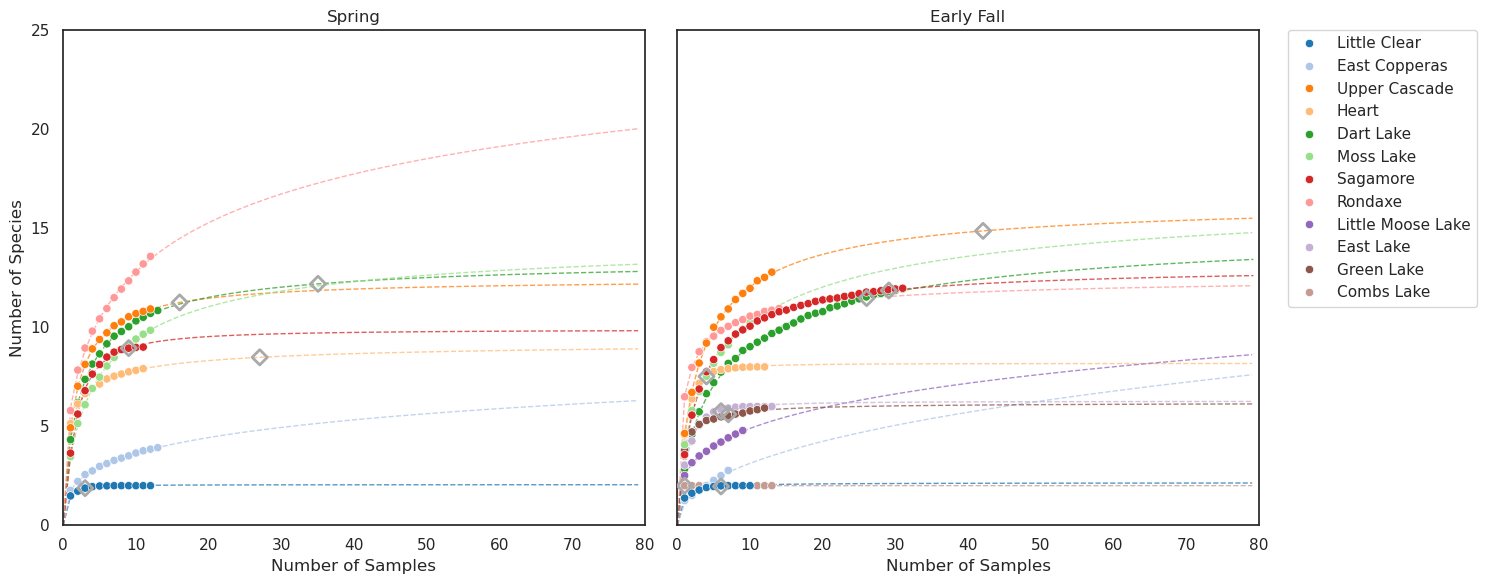

In [111]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6), sharey=True)

for i in all_lakes:
    try:
        sns.lineplot(data = (fitted_data[fitted_data["Name"] == i]
                         [fitted_data["Season"] == "Spring"]
                         [fitted_data["Number of Samples"] <= 80]).reset_index(drop=True), 
                   x = "Number of Samples", y = "Number of Species", palette = "tab20", linestyle='--',
                     hue = "Name", lw = 1, legend = False, hue_order=all_lakes, ax=axes[0], alpha = 0.75)
    except:
        pass
sns.scatterplot(data = plotting_accumulation[plotting_accumulation["Season"] == "Spring"].reset_index(drop=True), 
               x = "Number of Samples", y = "Number of Species", palette = "tab20",
                hue = "Name", zorder=7, ax=axes[0], legend = False, hue_order=all_lakes)#, legend = False)
ax1 = axes[0]
ax1.scatter(x = ninety["Number of Samples"][ninety["Season"] == "Spring"], 
            y = ninety["Number of Species"][ninety["Season"] == "Spring"],
                edgecolors = "darkgrey", marker = 'D', facecolors='none', 
            s = 60, zorder=8, lw=2.0)


for i in all_lakes:
    try:
        sns.lineplot(data = (fitted_data[fitted_data["Name"] == i]
                         [fitted_data["Season"] == "Early Fall"]
                         [fitted_data["Number of Samples"] <= 80]).reset_index(drop=True), 
                   x = "Number of Samples", y = "Number of Species", palette = "tab20", linestyle='--',
                     hue = "Name", lw = 1, legend = False, hue_order=all_lakes, ax=axes[1], alpha = 0.75)
    except:
        pass
sns.scatterplot(data = plotting_accumulation[plotting_accumulation["Season"] == "Early Fall"].reset_index(drop=True), 
               x = "Number of Samples", y = "Number of Species", palette = "tab20",
                hue = "Name", zorder=7, ax=axes[1], hue_order=all_lakes)
ax2 = axes[1]
ax2.scatter(x = ninety["Number of Samples"][ninety["Season"] == "Early Fall"], 
            y = ninety["Number of Species"][ninety["Season"] == "Early Fall"],
                edgecolors = "darkgrey", marker = 'D', facecolors='none', 
            s = 60, zorder=8, lw=2.0)


axes[0].set_title("Spring")
axes[1].set_title("Early Fall")
# Add legend (shared between both subplots)
axes[0].set_xlim(0, 80)
axes[0].set_ylim(0, 25)
axes[1].set_xlim(0, 80)
axes[1].set_ylim(0, 25)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tight_layout()
plt.savefig("../extrapolated_accumulation_outlier_removed.pdf", dpi = 300)